**Dado la falta de datos completos y consistentes que capturen los signos vitales, se ha optado por generar datos sintéticos 
que se adapten más al diseño de nuestro sistema. 
Para crear el primer dataset, con datos de salud maternos tomados en tiempos discretos, se ha usado la librería sdv
de python.**

A partir del dataset Maternal Health Risk, queremos obtener datos sintéticos, que sigan los ismos patrones que el dataset encontrado, para poder disponer de más datos con el que entrenar a nuestro modelo. 

Esta librería además, se usará para simular diferentes historias de usuarios y simular su 
desarrollo y seguimiento durante los meses de gestación. 

In [21]:
from ctgan import CTGAN

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import KMeans

from datetime import date
from datetime import datetime
from datetime import timedelta


# Configurar Seaborn para gráficos más bonitos
sns.set(style="whitegrid")


In [25]:
df= pd.read_csv('Maternal Health Risk Data Set.csv')

# ANÁLISIS DEL DATASET 

<ol>
    <li>Limpieza del dataset: tipos de datos, identificación de valores nulos, valores atípicos. </li>
    <li>Verificar rangos de valores.</li>
</ol>

In [47]:
print(f"Tipos de datos del dataset :\n\n {df.dtypes}")
print(f"\nBuscamos si hay valores nulos en las columnas:\n", df.isnull().sum())

Tipos de datos del dataset :

 Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object

Buscamos si hay valores nulos en las columnas:
 Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


Observamos que la mayoría de los datos son enteros, salvo el azúcar en sangre y la temperatura. 
También vemos que no hay valores nulos que tratar. 


## Análisis estadístico

In [51]:
print("\nVista del dataframe:\n")
df.head()


Vista del dataframe:



,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [53]:
data_dup = df.duplicated().any()
data_dup

True

In [55]:
print("\nEstadísticas del dataframe\n")
print(df.describe())


Estadísticas del dataframe

               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std      13.474386    18.403913    13.885796     3.293532     1.371384   
min      10.000000    70.000000    49.000000     6.000000    98.000000   
25%      19.000000   100.000000    65.000000     6.900000    98.000000   
50%      26.000000   120.000000    80.000000     7.500000    98.000000   
75%      39.000000   120.000000    90.000000     8.000000    98.000000   
max      70.000000   160.000000   100.000000    19.000000   103.000000   

         HeartRate  
count  1014.000000  
mean     74.301775  
std       8.088702  
min       7.000000  
25%      70.000000  
50%      76.000000  
75%      80.000000  
max      90.000000  


In [57]:
def verifica_rango(dataframe):
    
    rangos_limites = {
        'SystolicBP': (70,200),
        'DiastolicBP':(40,120),
        'BodyTemp': (82,106.5),
        'BS':(2.22,33.3),
        'HeartRate':(30,200),
    }
    
    results= {}
    for col, (min_val, max_val) in rangos_limites.items():
        if col in dataframe.columns:
            
            validos = dataframe[(dataframe[col] >= min_val) & (dataframe[col] <= max_val)]
            fuera_rango = len(dataframe) - len(validos)
            results[col] = {
                'val_fuera_rango':fuera_rango,
                'total_filas': len(dataframe), 
                'valores_validos': len(validos)
            }

    for col, info in results.items():
        print(f"- Valores fuera del rango de {col}:{info['val_fuera_rango']}\n")
        print(f"- Total valores de {col}:{info['total_filas']}\n")
        print(f"- Valores validos de {col}: {info['valores_validos']}\n")
    

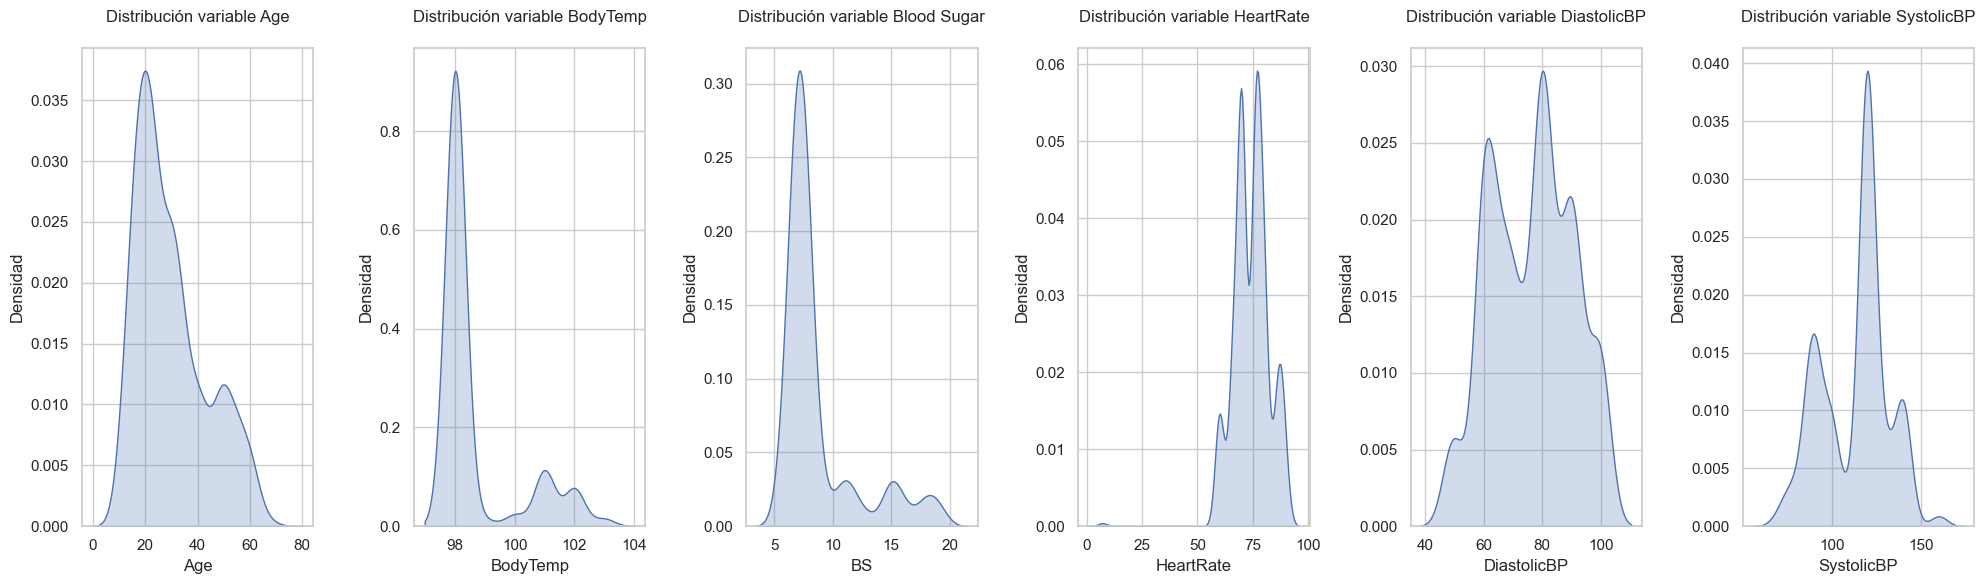

In [59]:
fig, axes = plt.subplots(1, 6, figsize=(20, 6))  # Crear un subplot con 6 gráficos

# Lista de variables y sus títulos
variables = [
    ('Age', 'Distribución variable Age\n'),
    ('BodyTemp', 'Distribución variable BodyTemp\n'),
    ('BS', 'Distribución variable Blood Sugar\n'),
    ('HeartRate', 'Distribución variable HeartRate\n'),
    ('DiastolicBP', 'Distribución variable DiastolicBP\n'),
    ('SystolicBP', 'Distribución variable SystolicBP\n')
]

# Graficar cada variable en su respectivo eje
for ax, (var, title) in zip(axes, variables):
    sns.kdeplot(data=df, x=var, fill=True, ax=ax)  # Graficar en el eje correspondiente
    ax.set_title(title)
    ax.set_xlabel(var)
    ax.set_ylabel('Densidad')

# Ajustar diseño
plt.tight_layout()
plt.show()

Vamos a observar la distribución que siguen nuestros datos y comprobar si hay valores extremos, para ello usaremos diagramas *boxplots*. 

C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\2386493748.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df['Age'], ax=axes[0], orient = "v", legend = False, linewidth = 1,
C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\2386493748.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df['BodyTemp'], ax=axes[1], orient = "v", legend = False, linewidth = 1,
C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\2386493748.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df['BS'], ax=axes[2],  orient =

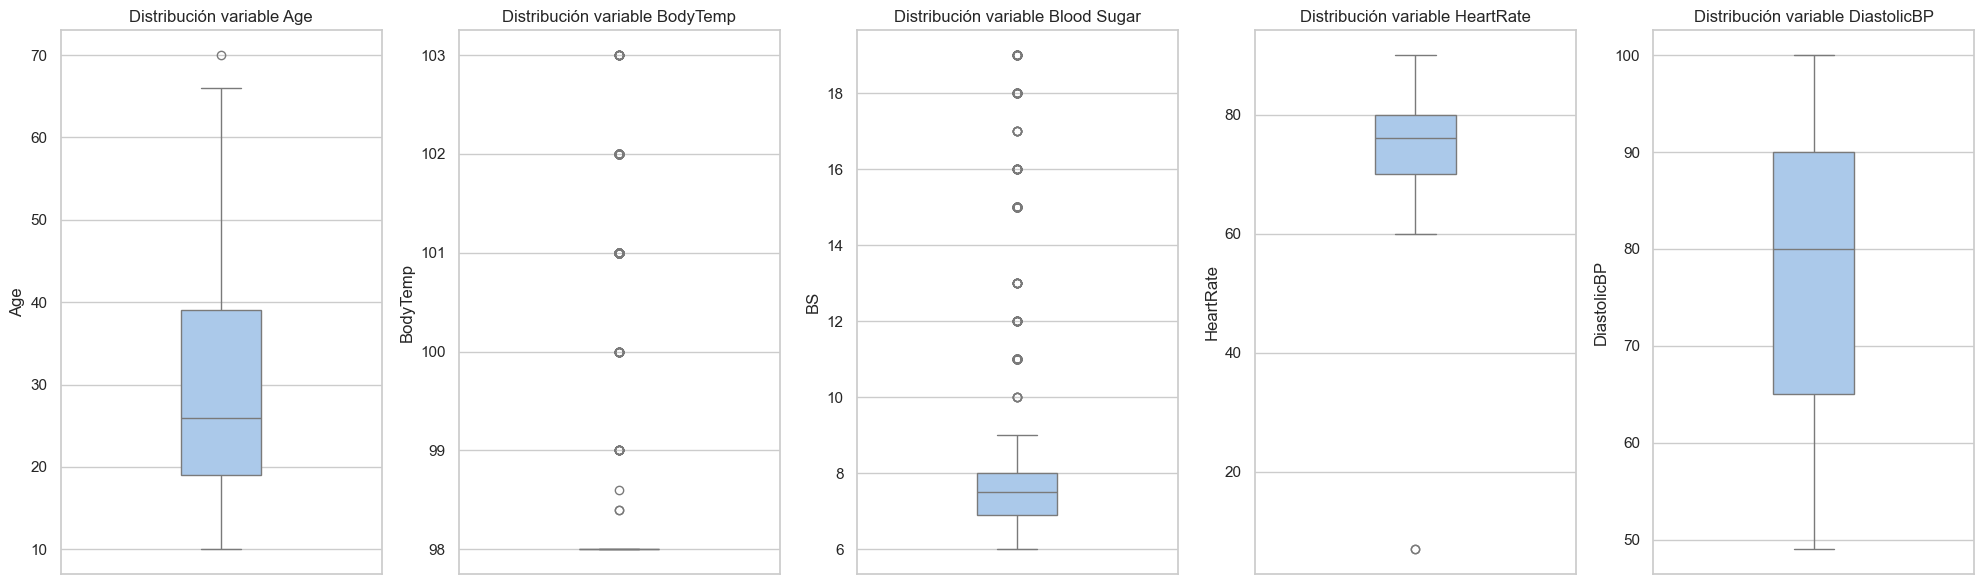

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

fig, axes = plt.subplots(1, 5, figsize=(20, 6))

#Diagrama columna 'Age'
sns.boxplot(y=df['Age'], ax=axes[0], orient = "v", legend = False, linewidth = 1,
           native_scale=True, width = .25, palette = "pastel", color = '#a1c9f4')
axes[0].set_title('Distribución variable Age')

#Diagrama BodyTemp
sns.boxplot(y=df['BodyTemp'], ax=axes[1], orient = "v", legend = False, linewidth = 1,
            native_scale=True, width = .25, palette = "pastel", color = '#8de5a1')
axes[1].set_title('Distribución variable BodyTemp')

# Boxplot para BS (Blood Sugar)
sns.boxplot(y=df['BS'], ax=axes[2],  orient = "v", legend = False, linewidth = 1,native_scale=True, 
            width = .25, palette = "pastel", color = '#ff9f9b')
axes[2].set_title('Distribución variable Blood Sugar')

# Boxplot para HeartRate
sns.boxplot(y=df['HeartRate'], ax=axes[3], orient = "v", legend = False, linewidth = 1,
            native_scale=True, width = .25, palette = "pastel", color = '#d0bbff')
axes[3].set_title('Distribución variable HeartRate')

# Boxplot para SystolicBP
sns.boxplot(y=df['DiastolicBP'], ax= axes[4], orient = "v", legend = False, linewidth = 1,
           native_scale=True, width = .25, palette = "pastel",color = '#fffea3')
axes[4].set_title('Distribución variable DiastolicBP')

plt.tight_layout()
plt.show()


In [64]:
# 5. **Verificar duplicados**
# Verificar y eliminar filas duplicadas si es necesario
print(f"Número de filas duplicadas: {df.duplicated().sum()}")
df = df.drop_duplicates()  # Eliminar filas duplicadas

# 6. **Verificar rangos válidos para las variables**:
# Comprobar si los valores están dentro de los rangos fisiológicos razonables
verifica_rango(df)

# 7. **Comprobar las correlaciones**:
# Verificar las correlaciones generales antes de dividir en patológicos y sanos
corr_matrix = df[['Age','SystolicBP', 'DiastolicBP', 'BodyTemp', 'BS', 'HeartRate']].corr()
print("Matriz de correlación general:\n", corr_matrix)



Número de filas duplicadas: 562
- Valores fuera del rango de SystolicBP:0

- Total valores de SystolicBP:452

- Valores validos de SystolicBP: 452

- Valores fuera del rango de DiastolicBP:0

- Total valores de DiastolicBP:452

- Valores validos de DiastolicBP: 452

- Valores fuera del rango de BodyTemp:0

- Total valores de BodyTemp:452

- Valores validos de BodyTemp: 452

- Valores fuera del rango de BS:0

- Total valores de BS:452

- Valores validos de BS: 452

- Valores fuera del rango de HeartRate:1

- Total valores de HeartRate:452

- Valores validos de HeartRate: 451

Matriz de correlación general:
                   Age  SystolicBP  DiastolicBP  BodyTemp        BS  HeartRate
Age          1.000000    0.375931     0.347846 -0.188843  0.376616   0.077407
SystolicBP   0.375931    1.000000     0.790002 -0.207267  0.347534  -0.006088
DiastolicBP  0.347846    0.790002     1.000000 -0.201992  0.300423  -0.016470
BodyTemp    -0.188843   -0.207267    -0.201992  1.000000 -0.042511   0.087

Queríamos ver si hay outliers fuera de los rangos fisiológicos incompatibles con la vida, pero hemos podido comprobar que ninguno se sale de los rangos posibles. Así no tenemos que limpiarlo, porque los outliers nos interesan para tener más casos de usuarios y entrenar a nuestros modelos. 

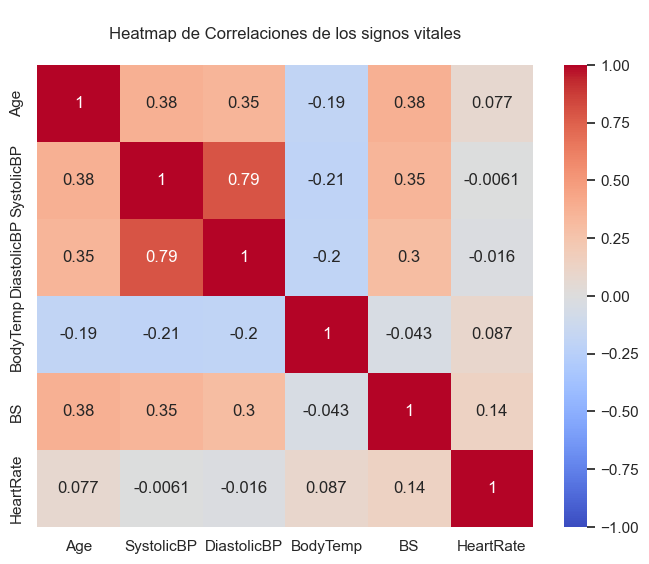

In [67]:
# 8. **Visualizar correlaciones** con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("\nHeatmap de Correlaciones de los signos vitales\n")
plt.show()

Las variables que más correlacionadas están son:
<ol>
    <li> La presión sistólica y diastólica: Una aumenta en respuesto al aumento de la otra. </li>
    <li>La edad y la presión sistólica, la edad y la presión diastólica: cuánto más mayores nos hacemos, aumenta la presión, cobra sentido
    ya que los vasos sanguíneos son cada vez menos flexible y el corazón bombea con menos fuerza</li>
    <li>La edad y el azúcar en sangre: según vamos envejeciendo, disminuye la producción de insulina y aumenta la resistencia a esta, 
    es por ello que procesamos peor el azúcar que ingerimos. </li>


Por último vamos a comprobar la distribución de las etiquetas, para saber cómo son las pacientes
en los que nos basamos, si la mayoría enfermas, o sanas, o si hablamos de una muestra balanceada. 

Frecuencia niveles de riesgo en la muestra de pacientes:  RiskLevel
low risk     234
high risk    112
mid risk     106
Name: count, dtype: int64


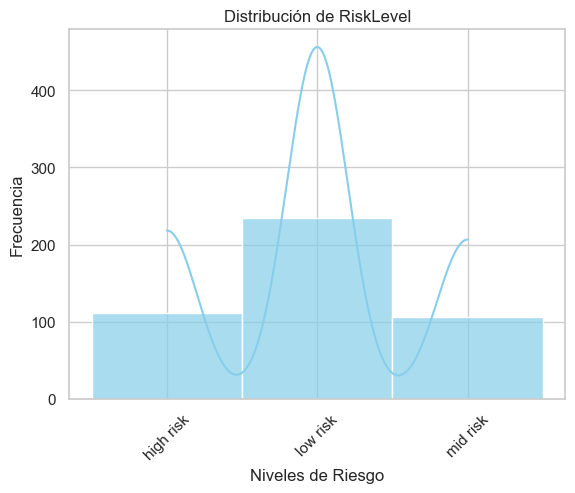

In [71]:

print(f"Frecuencia niveles de riesgo en la muestra de pacientes:  {df['RiskLevel'].value_counts()}")

sns.histplot(data=df, x='RiskLevel', discrete=True, kde=True, color='skyblue', alpha=0.7)
plt.title('Distribución de RiskLevel')
plt.xlabel('Niveles de Riesgo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

Observamos que la mayoría (más de la mitad) de las pacientes son sanas, y presentan bajo riesgo en su embarazo. 



---

# CREACIÓN DATOS SINTÉTICOS SALUD MATERNA

# Creación de datos sintéticos wearable

La sección de generación del dataset crea datos sintéticos de signos vitales continuos para cada usuario y marca de tiempo. Se basa en los valores iniciales del archivo CSV y simula la variabilidad fisiológica utilizando distribuciones de probabilidad y patrones temporales.

Simulación de la presión arterial: Tanto la presión arterial sistólica (SystolicBP) como la diastólica (DiastolicBP) se simulan utilizando una distribución normal truncada (scipy.stats.truncnorm). Esto permite generar valores realistas que se agrupan alrededor de la media de cada usuario (obtenida del CSV), pero que se mantienen dentro de límites fisiológicos plausibles (70-190 mmHg para sistólica, 40-120 mmHg para diastólica). La desviación estándar de la distribución se ajusta para controlar la variabilidad de los datos sintéticos. Finalmente, los valores se redondean al entero más cercano.

Simulación de la glucosa en sangre: La glucosa en sangre (BS) se modela considerando una variación diurna. Se añade una onda sinusoidal a los valores base para simular las fluctuaciones diarias típicas relacionadas con la ingesta de alimentos y el ayuno. Además, se introduce ruido aleatorio mediante una distribución normal para representar la variabilidad individual y las fluctuaciones a lo largo del tiempo.

Simulación de la temperatura corporal: La temperatura corporal (BodyTemp) se simula utilizando una distribución normal centrada en la temperatura base de cada usuario (del CSV) con una pequeña desviación estándar, reflejando las fluctuaciones normales de la temperatura corporal.

Simulación de la frecuencia cardíaca: Similar a la presión arterial, la frecuencia cardíaca (HeartRate) se genera con una distribución normal truncada (truncnorm) para mantener los valores dentro de un rango fisiológico (40-120 lpm) y centrados en la frecuencia cardíaca base de cada usuario. Los valores generados también se redondean al entero más cercano.

Vectorización y formato del DataFrame: Para una mayor eficiencia, todas las operaciones de generación de datos se realizan utilizando funciones vectorizadas de NumPy. Esto permite generar los datos para todos los usuarios y marcas de tiempo simultáneamente, en lugar de iterar a través de bucles. Finalmente, los arrays resultantes se aplanan utilizando .flatten() para convertirlos en arrays 1D y poder insertarlos correctamente en las columnas correspondientes del DataFrame wearable_df.

A continuación se presenta un desglose de las variables que suelen considerarse distribuidas normalmente o de forma gaussiana, y cómo generar datos simulados más realistas:
<ol>
    <li>Presión arterial sistólica (PSistólica) y presión arterial diastólica (PDiastólica): Suelen tener una distribución aproximadamente normal en poblaciones sanas, pero pueden estar sesgadas en individuos con hipertensión u otras afecciones.
</li>
<li>Azúcar en sangre (BS): El azúcar en sangre no suele tener una distribución normal. Tiende a aumentar después de las comidas y a disminuir durante los periodos de ayuno. Modelarlo como normal podría ser engañoso, especialmente para pacientes con diabetes.</li>

<li>Temperatura corporal (BT/BodyTemp): La temperatura corporal se distribuye de forma aproximadamente normal en torno a un punto de referencia (por ejemplo, 37 °C o 98,6 °F), pero con una desviación estándar relativamente pequeña.</li></ol>



In [105]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import scipy.stats as stats

df = pd.read_csv("synthetic_vital_signs.csv")
n_users = len(df)

# Create timestamps for the 3-month period (Jan 1st to Mar 31st)
timestamps = pd.date_range("2024-01-01", "2024-04-01", freq="h")
n_timestamps = len(timestamps)

# Create the DataFrame directly
wearable_df = pd.DataFrame({
    "User ID": np.repeat(df.index.values, n_timestamps),
    "Timestamp": np.tile(timestamps, n_users),
    "Age": np.repeat(df.Age.values, n_timestamps),
})
wearable_df =wearable_df.set_index("Timestamp")

# Generate simulated data using vectorized operations
wearable_df["SystolicBP"] = np.round(stats.truncnorm.rvs(
    a=(70 - df.SystolicBP.values[:, None]) / 5,
    b=(190 - df.SystolicBP.values[:, None]) / 5,
    loc=df.SystolicBP.values[:, None],
    scale=5,
    size=(n_users, n_timestamps)
)).flatten()

wearable_df["DiastolicBP"] = np.round(stats.truncnorm.rvs(
    a=(40 - df.DiastolicBP.values[:, None]) / 3,
    b=(120 - df.DiastolicBP.values[:, None]) / 3,
    loc=df.DiastolicBP.values[:, None],
    scale=3,
    size=(n_users, n_timestamps)
)).flatten()

base_bs = np.repeat(df.BS.values[:, None], n_timestamps, axis=1) + np.random.normal(0, 0.5, size=(n_users, n_timestamps))
diurnal_variation = 0.1 * np.sin(2 * np.pi * np.arange(n_timestamps) / 24)
bs_values = base_bs + diurnal_variation
wearable_df["BS"] = bs_values.flatten()

body_temp_values = df.BodyTemp.values[:, None] + np.random.normal(0, 0.2, (n_users, n_timestamps))
wearable_df["BodyTemp"] = body_temp_values.flatten()

wearable_df["HeartRate"] = np.round(stats.truncnorm.rvs(
    a=(40 - df.HeartRate.values[:, None]) / 10,
    b=(120 - df.HeartRate.values[:, None]) / 10,
    loc=df.HeartRate.values[:, None],
    scale=10,
    size=(n_users, n_timestamps)
)).flatten()

wearable_df["HeartRate"]= wearable_df["HeartRate"].astype(int)

print(wearable_df)

                     User ID  Age  SystolicBP  DiastolicBP        BS  \
Timestamp                                                              
2024-01-01 00:00:00        0   22       125.0         63.0  8.381560   
2024-01-01 01:00:00        0   22       118.0         63.0  8.141058   
2024-01-01 02:00:00        0   22       122.0         63.0  7.074752   
2024-01-01 03:00:00        0   22       123.0         64.0  7.045845   
2024-01-01 04:00:00        0   22       118.0         62.0  7.810726   
...                      ...  ...         ...          ...       ...   
2024-03-31 20:00:00      499   15       134.0         65.0  6.399250   
2024-03-31 21:00:00      499   15       128.0         56.0  6.252180   
2024-03-31 22:00:00      499   15       123.0         61.0  6.438263   
2024-03-31 23:00:00      499   15       133.0         61.0  7.486472   
2024-04-01 00:00:00      499   15       131.0         60.0  6.595883   

                       BodyTemp  HeartRate  
Timestamp         

Este dataset recoge datos calculados para 3 meses de signos vitales, pero sin etiquetar, para que sea el propio algoritmo el que lo haga. Como tenemos demasiados datos, vamos a limitar a 12h donde recogemos datos de los pacientes (500), en vez de por hora (24 datos a lo largo del día), ya que no es tan significativo de hora a hora la variación de los datos, pues no se tratan de enfermedades tan críticas como se pueden tratar en los cuidados paliativos. 

In [110]:
import pandas as pd
import numpy as np

hours_per_user = 12

# 1. Verificar las correlaciones originales en el dataset
correlation_matrix = wearable_df[['Age', 'SystolicBP', 'DiastolicBP', 'BodyTemp', 'BS', 'HeartRate']].corr()
print(correlation_matrix)

# 2. Aplicar las correlaciones deseadas según la matriz de correlación del primer dataset
desired_correlations = {
    'DiastolicBP_Age': 0.35,
    'DiastolicBP_SystolicBP': 0.79,
    'DiastolicBP_BS': 0.30,
    'DiastolicBP_BodyTemp': -0.20,
    'SystolicBP_Age': 0.38,
    'SystolicBP_BS': 0.35,
    'SystolicBP_BodyTemp': -0.21,
    'BS_Age': 0.38, 
    'BodyTemp_Age': -0.19, 
    'BodyTemp_SystolicBP': -0.21, 
    'BS_SystolicBP': 0.35, 
    'BodyTemp_DiastolicBP': -0.20, 
    'BS_DiastolicBP': 0.30, 
    'BS_BodyTemp': -0.043, 
    'HeartRate_BS': 0.14
    
}

# 3. Generar correlaciones deseadas usando la Cholesky Decomposition
# Crear la matriz de covarianza basada en las correlaciones proporcionadas
cov_matrix = np.array([
    [1, desired_correlations['SystolicBP_Age'], desired_correlations['DiastolicBP_Age'], desired_correlations['BodyTemp_Age'], desired_correlations['BS_Age'], 0],
    [desired_correlations['SystolicBP_Age'], 1, desired_correlations['DiastolicBP_SystolicBP'], desired_correlations['BodyTemp_SystolicBP'], desired_correlations['BS_SystolicBP'], 0],
    [desired_correlations['DiastolicBP_Age'], desired_correlations['DiastolicBP_SystolicBP'], 1, desired_correlations['BodyTemp_DiastolicBP'], desired_correlations['BS_DiastolicBP'], 0],
    [desired_correlations['BodyTemp_Age'], desired_correlations['BodyTemp_SystolicBP'], desired_correlations['BodyTemp_DiastolicBP'], 1, desired_correlations['BS_BodyTemp'], 0],
    [desired_correlations['BS_Age'], desired_correlations['BS_SystolicBP'], desired_correlations['BS_DiastolicBP'], desired_correlations['BS_BodyTemp'], 1, desired_correlations['HeartRate_BS']],
    [0, 0, 0, 0, desired_correlations['BS_Age'], 1]  # Correlación entre HeartRate y BS se ha omitido
])

# Usar la factorización Cholesky para generar variables con las correlaciones deseadas

cholesky_matrix = np.linalg.cholesky(cov_matrix)
synthetic_data = np.dot(np.random.randn(len(wearable_df), 6), cholesky_matrix.T)

# 5. Crear un DataFrame con los datos sintéticos generados
synthetic_df = pd.DataFrame(synthetic_data, columns=['Age', 'SystolicBP', 'DiastolicBP', 'BodyTemp', 'BS', 'HeartRate'])

# Add diurnal variations (e.g., for BodyTemp, BS)
time_series = np.tile(np.arange(hours_per_user), n_users)

diurnal_variation_bs = 0.1 * np.sin(2 * np.pi * time_series / 24)

diurnal_variation_body_temp = 1.8 * np.sin((3/2)* np.pi * time_series / 24) #latemperatura varía de 97.7ºF-99.5ºF

diurnal_variation_heart_rate = np.round( np.sin(2 * np.pi * time_series / 24),0)

# **Variación diurna para Presión Arterial (Diastolic BP)**
# Forma tipo campana de Gauss: máximo a las 12 p.m. (las 6 primeras horas)
# Usamos una forma de campana de Gauss centrada en las 12 p.m. (hora 6)
diurnal_variation_bp = np.exp(-0.5 * ((time_series - 6) / 2) ** 2)
diurnal_variation_systolic_bp = np.exp(-0.5 * ((time_series - 6) / 2) ** 2)

 #**Fluctuaciones patológicas independientes** (esto no se ve afectado por la amplitud base)
# Variabilidad patológica (simula fluctuaciones como en hipertensión)
pathological_fluctuations_bp = np.random.normal(0, 5, size=(n_users * hours_per_user))  # Picos aleatorios de hipertensión

# Variabilidad patológica se agrega sin truncar la onda base
diurnal_variation_bp += pathological_fluctuations_bp  # Fluctuaciones independientes
diurnal_variation_systolic_bp += pathological_fluctuations_bp 

#Redondeamos HR, SBP, DBP:
diurnal_variation_heart_rate = np.round(diurnal_variation_heart_rate).astype(int)
diurnal_variation_bp = np.round(diurnal_variation_bp).astype(int)
diurnal_variation_systolic_bp = np.round(diurnal_variation_systolic_bp).astype(int)

#Creamos dataset final con serie temporal  y correlaciones
data = {
    'Age': np.repeat(df.Age.values[:n_users], hours_per_user),
    'SystolicBP': np.repeat(df.SystolicBP.values[:n_users], hours_per_user) + diurnal_variation_systolic_bp,  # Agregar fluctuación diaria
    'DiastolicBP': np.repeat(df.DiastolicBP.values[:n_users], hours_per_user) + diurnal_variation_bp,  # Agregar fluctuación diaria
    'BodyTemp': np.repeat(df.BodyTemp.values[:n_users], hours_per_user) + diurnal_variation_body_temp,  # Add daily fluctuation
    'BS': np.repeat(df.BS.values[:n_users], hours_per_user) + diurnal_variation_bs,  # Add daily fluctuation
    'HeartRate': np.repeat(df.HeartRate.values[:n_users], hours_per_user) + diurnal_variation_heart_rate,  # Add daily fluctuation
}

timestamps = pd.date_range("2024-01-01", periods=hours_per_user, freq="h")
data['Timestamp'] = np.tile(timestamps, n_users)
data['User ID'] = np.repeat(range(n_users), hours_per_user)



# 7. Mostrar el DataFrame con las correlaciones aplicadas
#import ace_tools as tools; tools.display_dataframe_to_user(name="Synthetic Wearable Dataset with Time Series and Correlations", dataframe=synthetic_df)

# Verificar las primeras filas del DataFrame generado
pd.DataFrame(data)
synthetic_df= pd.DataFrame(data)
synthetic_df["HeartRate"] = final_df["HeartRate"].astype(int) #que sean datos tipo int y no float
    # Add timestamps and user IDs


                  Age  SystolicBP  DiastolicBP  BodyTemp        BS  HeartRate
Age          1.000000    0.003148     0.092136 -0.074981  0.058693   0.011248
SystolicBP   0.003148    1.000000     0.029853 -0.039132  0.018919  -0.008008
DiastolicBP  0.092136    0.029853     1.000000 -0.036270  0.077719   0.046937
BodyTemp    -0.074981   -0.039132    -0.036270  1.000000 -0.048143   0.001846
BS           0.058693    0.018919     0.077719 -0.048143  1.000000  -0.019425
HeartRate    0.011248   -0.008008     0.046937  0.001846 -0.019425   1.000000


In [112]:
synthetic_df.head()

,Age,SystolicBP,DiastolicBP,BodyTemp,BS,HeartRate,Timestamp,User ID
0,22,115,60,98.000000,7.970000,70,2024-01-01 00:00:00,0
1,22,117,62,98.351163,7.995882,70,2024-01-01 01:00:00,0
2,22,122,67,98.688830,8.020000,70,2024-01-01 02:00:00,0
3,22,123,68,99.000026,8.040711,71,2024-01-01 03:00:00,0
4,22,127,72,99.272792,8.056603,71,2024-01-01 04:00:00,0


Ahora vamos a aseguranos que sigue las variables se encuentra entre los datos fisiologicos válidos, tal y como hemos hecho en el base

In [116]:
# 5. **Verificar duplicados**
# Verificar y eliminar filas duplicadas si es necesario
print(f"Número de filas duplicadas: {synthetic_df.duplicated().sum()}")
synthetic_df = synthetic_df.drop_duplicates()  # Eliminar filas duplicadas
print(len(synthetic_df))
# 6. **Verificar rangos válidos para las variables**:
# Comprobar si los valores están dentro de los rangos fisiológicos razonables
verifica_rango(synthetic_df)




Número de filas duplicadas: 0
6000
- Valores fuera del rango de SystolicBP:86

- Total valores de SystolicBP:6000

- Valores validos de SystolicBP: 5914

- Valores fuera del rango de DiastolicBP:5

- Total valores de DiastolicBP:6000

- Valores validos de DiastolicBP: 5995

- Valores fuera del rango de BodyTemp:0

- Total valores de BodyTemp:6000

- Valores validos de BodyTemp: 6000

- Valores fuera del rango de BS:0

- Total valores de BS:6000

- Valores validos de BS: 6000

- Valores fuera del rango de HeartRate:0

- Total valores de HeartRate:6000

- Valores validos de HeartRate: 6000



Como el dataset base, no hay ningún dato que no sea posible o compatible con la vida.

### Comprobación y validación de la calidad dataset sintético

Hay que demostrar que nuestro dataset refleja datos del mundo real.

<ol>
    <li>Comparación de propiedades estadísticas</li>
    <li>Test estadísticos</li>
    <li>Comprobar consistencia temporal</li>


##### Propiedades estadísticas


Distribución de cada variable sintética debe ser similar a dataset base: Kernel Density Functions e histogramas

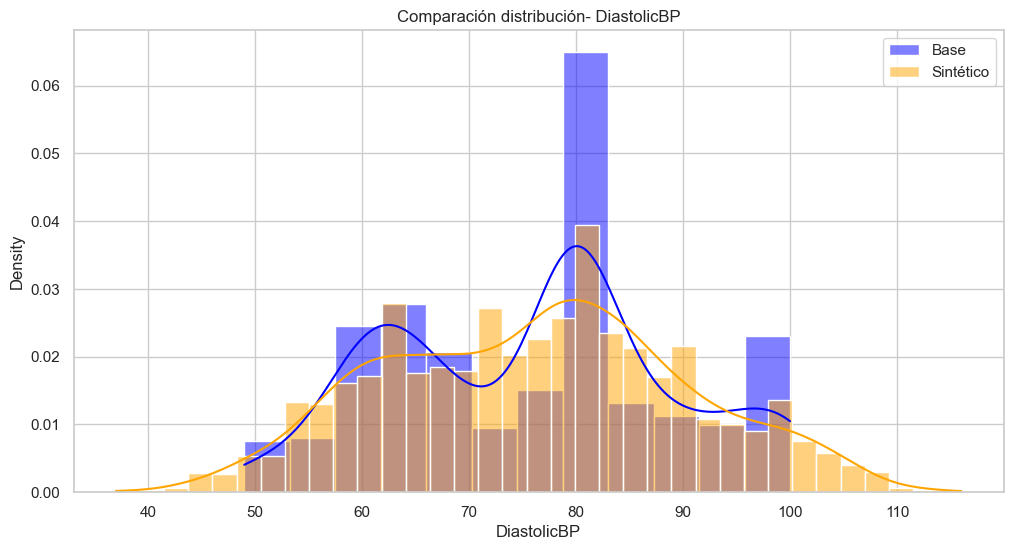

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable DiastolicBP

sns.histplot(df['DiastolicBP'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(synthetic_df['DiastolicBP'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución- DiastolicBP')
plt.show()

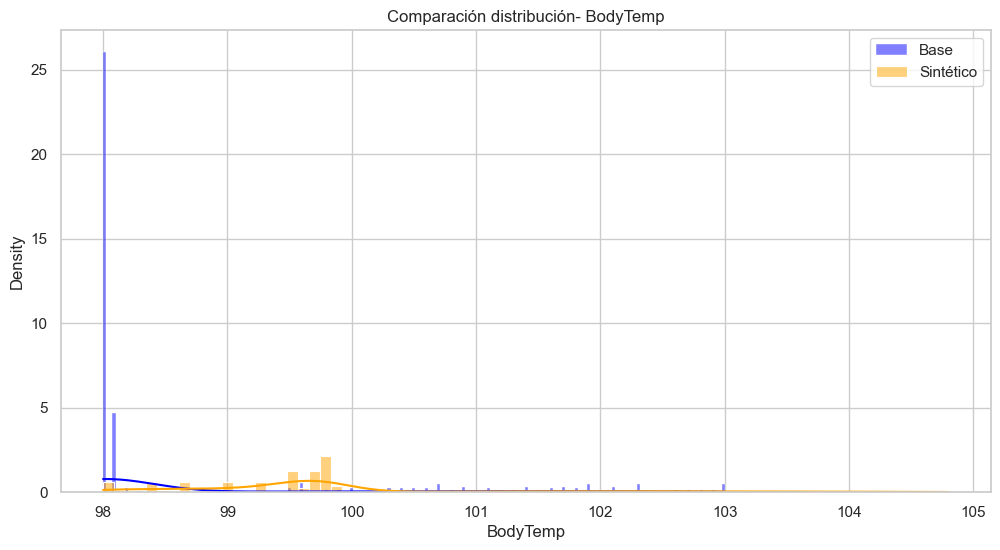

In [120]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable BodyTemp

sns.histplot(df['BodyTemp'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(synthetic_df['BodyTemp'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución- BodyTemp')
plt.show()

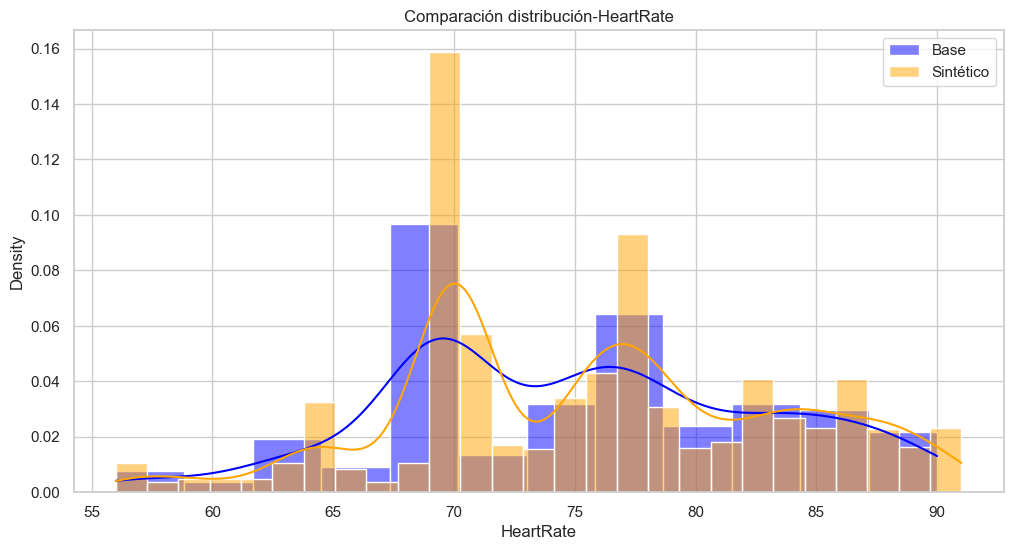

In [122]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable HeartRate

sns.histplot(df['HeartRate'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(synthetic_df['HeartRate'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-HeartRate')
plt.show()

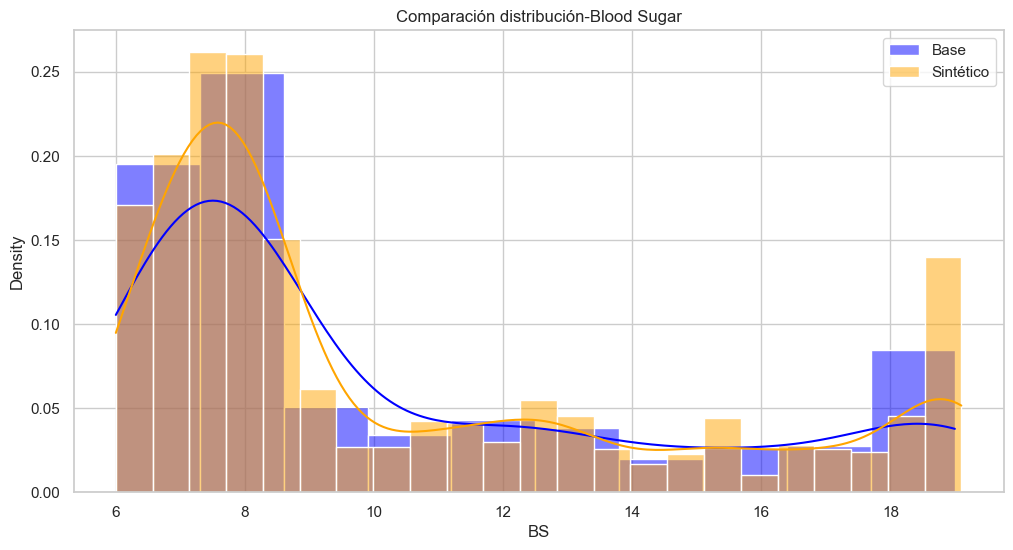

In [124]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable BloodSugar

sns.histplot(df['BS'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(synthetic_df['BS'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-Blood Sugar')
plt.show()

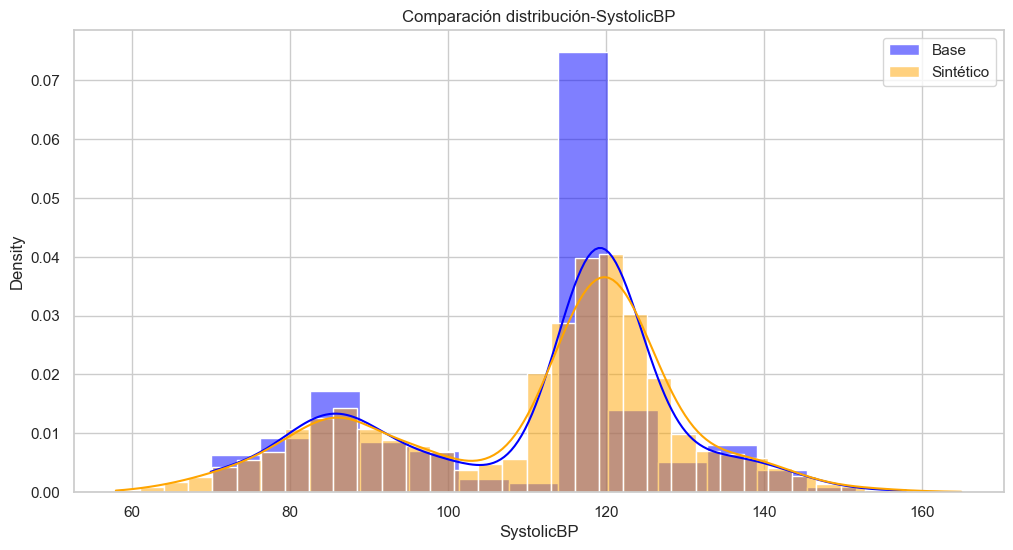

In [126]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable SystolicBP

sns.histplot(df['SystolicBP'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(synthetic_df['SystolicBP'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-SystolicBP')
plt.show()

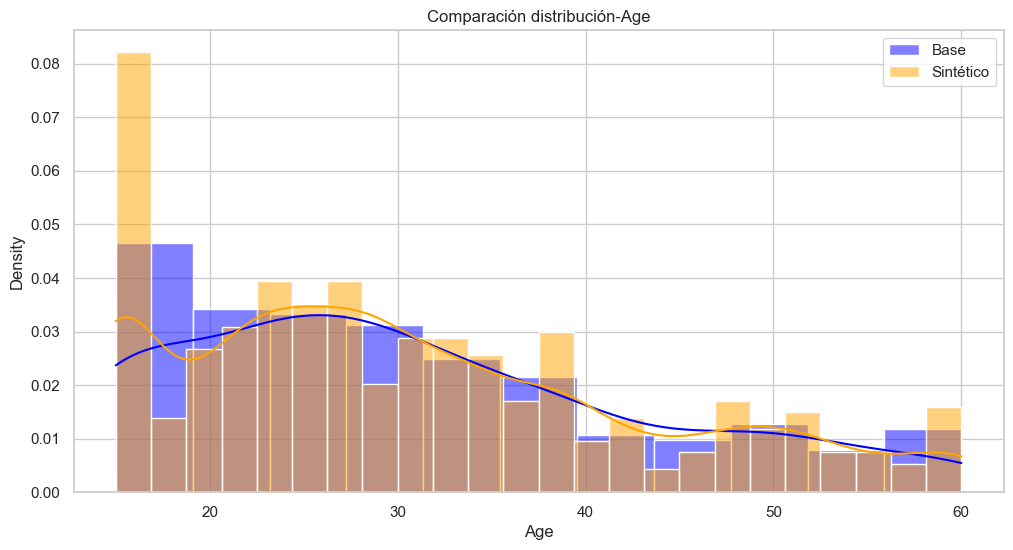

In [128]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable Age

sns.histplot(df['Age'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(synthetic_df['Age'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-Age')
plt.show()

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp


#Renombramos columnas dataframe sintetico

common_columns = [col for col in df.columns if col in synthetic_df.columns]

Results = {}
for column in common_columns:
    # Comprobar si la columna es numérica
    if pd.api.types.is_numeric_dtype(df[column]):
        
        # Kolmogorov-Smirnov Test
        ks_stat, p_value = ks_2samp(df[column], synthetic_df[column])
        Results[column] = {'KS Statistic': ks_stat, 'P-value': p_value}

# Convertir los resultados a un DataFrame para visualizarlos mejor
ksResults_finaldf = pd.DataFrame(Results).T
print(ksResults_finaldf)

             KS Statistic        P-value
Age              0.000000   1.000000e+00
SystolicBP       0.171667   2.386478e-12
DiastolicBP      0.091667   8.049680e-04
BS               0.056833   9.816406e-02
BodyTemp         0.715000  1.434103e-235
HeartRate        0.087500   1.610375e-03


Variables bien representadas: Age y BS muestran buena similitud entre los datasets base y generado, ya que tienen p-valores altos y bajos valores de KS Statistic.

Variables con diferencias significativas: SystolicBP, DiastolicBP, HeartRate y, especialmente, BodyTemp presentan diferencias importantes, lo que indica que el dataset sintético no captura adecuadamente la distribución de estas variables.

## USO DE TIME-DGAN PARA CREAR NUESTRO DATASET


In [134]:
wearable_df2= pd.read_csv('time-series-dgan-wearable-data.csv')

In [136]:
wearable_df2.head()

,UserID,Age,Timestamp,DiastolicBloodPressure,SystolicBloodPressure,BloodSugar,BodyTemp,HeartRate,example_id
0,user506,52.094318,23/07/2024 15:00:00,135.991180,150.846405,783.350708,108.887817,101.435196,0
1,user149,44.074669,19/07/2024 00:00:00,102.978188,145.868164,469.697052,101.269753,92.673508,0
2,user160,45.261963,19/07/2024 03:00:00,92.329315,138.263733,222.768784,101.198578,86.859909,0
3,user160,33.453758,19/07/2024 03:00:00,70.610886,128.307312,100.765686,98.940018,72.702194,0
4,user160,31.309391,19/07/2024 03:00:00,62.677235,119.778893,76.167435,97.968826,70.279549,0


##### Arreglos del dataset

Vamos a pasar a numeros enteros los valores de la columna Age, DiastolicBloodPressure, SystolicBloodPressure y HeartRate. 
Además, vamos a eliminar la columna example_id ya que ha sido el algoritmo quien lo ha puesto automaticamente para parecerse al datasetbase, y esto
no nos hace falta. 

Finalmente lo que vamos a hacer es transformar la columna de BloodSugar de mg/dl a mmol/l como viene en el dataset de Maternal Health Risk. 

In [138]:

#1. conversion a enteros
columns_to_convert = ['Age', 'DiastolicBloodPressure', 'SystolicBloodPressure', 'HeartRate']
for col in columns_to_convert:
    wearable_df2[col] = wearable_df2[col].astype(int) 

#2. Elimino example_id
if 'example_id' in wearable_df2.columns:
    wearable_df2.drop(columns=['example_id'], inplace=True)


#3. Conversion mg/dl a mmol/L
wearable_df2['BloodSugar'] = wearable_df2['BloodSugar'] / 18

wearable_df2.head()


,UserID,Age,Timestamp,DiastolicBloodPressure,SystolicBloodPressure,BloodSugar,BodyTemp,HeartRate
0,user506,52,23/07/2024 15:00:00,135,150,43.519484,108.887817,101
1,user149,44,19/07/2024 00:00:00,102,145,26.094281,101.269753,92
2,user160,45,19/07/2024 03:00:00,92,138,12.376044,101.198578,86
3,user160,33,19/07/2024 03:00:00,70,128,5.598094,98.940018,72
4,user160,31,19/07/2024 03:00:00,62,119,4.231524,97.968826,70


In [140]:
wearable_df2.describe()

,Age,DiastolicBloodPressure,SystolicBloodPressure,BloodSugar,BodyTemp,HeartRate
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,48.484060,102.020400,141.286000,18.431324,104.351433,100.398640
std,17.714598,39.987276,18.575401,17.067665,6.302991,24.738146
min,19.000000,60.000000,106.000000,4.058660,96.536278,64.000000
25%,34.000000,64.000000,127.000000,4.306921,98.342352,78.000000
50%,49.000000,92.000000,143.000000,9.656615,103.687057,101.000000
75%,61.000000,133.000000,155.000000,30.633499,108.940104,118.000000
max,98.000000,223.000000,204.000000,77.945082,121.943634,162.000000


In [142]:
# 5. **Verificar duplicados**
# Verificar y eliminar filas duplicadas si es necesario
print(f"Número de filas duplicadas: {wearable_df2.duplicated().sum()}")
#df_dgan= df_dgan.drop_duplicates()  # Eliminar filas duplicadas

# 6. **Verificar rangos válidos para las variables**:
# Comprobar si los valores están dentro de los rangos fisiológicos razonables
verifica_rango(wearable_df2)


Número de filas duplicadas: 0
- Valores fuera del rango de BodyTemp:18253

- Total valores de BodyTemp:50000

- Valores validos de BodyTemp: 31747

- Valores fuera del rango de HeartRate:0

- Total valores de HeartRate:50000

- Valores validos de HeartRate: 50000



##### Búsqueda y manejo de outliers

C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\4282838085.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=wearable_df2['Age'], ax=axes[0], orient = "v", legend = False, linewidth = 1,
C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\4282838085.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=wearable_df2['BodyTemp'], ax=axes[1], orient = "v", legend = False, linewidth = 1,
C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\4282838085.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=wearable_df2[

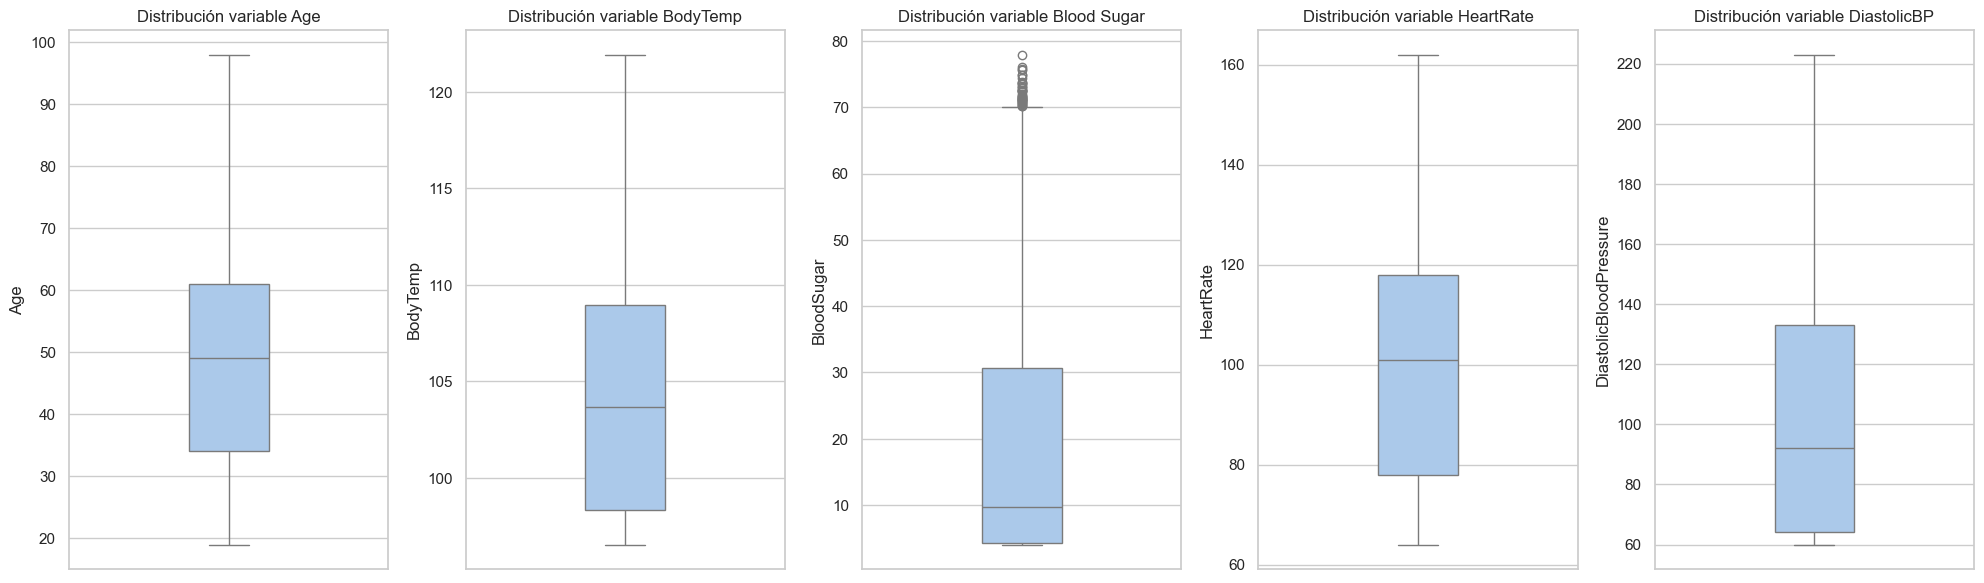

In [144]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

#Diagrama columna 'Age'
sns.boxplot(y=wearable_df2['Age'], ax=axes[0], orient = "v", legend = False, linewidth = 1,
           native_scale=True, width = .25, palette = "pastel", color = '#a1c9f4')
axes[0].set_title('Distribución variable Age')

#Diagrama BodyTemp
sns.boxplot(y=wearable_df2['BodyTemp'], ax=axes[1], orient = "v", legend = False, linewidth = 1,
            native_scale=True, width = .25, palette = "pastel", color = '#8de5a1')
axes[1].set_title('Distribución variable BodyTemp')

# Boxplot para BS (Blood Sugar)
sns.boxplot(y=wearable_df2['BloodSugar'], ax=axes[2],  orient = "v", legend = False, linewidth = 1,native_scale=True, 
            width = .25, palette = "pastel", color = '#ff9f9b')
axes[2].set_title('Distribución variable Blood Sugar')

# Boxplot para HeartRate
sns.boxplot(y=wearable_df2['HeartRate'], ax=axes[3], orient = "v", legend = False, linewidth = 1,
            native_scale=True, width = .25, palette = "pastel", color = '#d0bbff')
axes[3].set_title('Distribución variable HeartRate')

# Boxplot para SystolicBP
sns.boxplot(y=wearable_df2['DiastolicBloodPressure'], ax= axes[4], orient = "v", legend = False, linewidth = 1,
           native_scale=True, width = .25, palette = "pastel",color = '#fffea3')
axes[4].set_title('Distribución variable DiastolicBP')

plt.tight_layout()
plt.show()

Eliminamos los outliers que se salen de los valores compatibles con la vida

In [148]:
# 1. Definir los rangos válidos para cada variable
valid_ranges = {
    'BodyTemp': (82, 106.5),  # Rango fisiológico de temperatura corporal (Fahrenheit)
    'BloodSugar': (2.2, 33.3),  # Azúcar en sangre (mmol/L)
    'SystolicBloodPressure': (70, 180),  # Presión sistólica (mmHg)
    'DiastolicBloodPressure': (40, 120)  # Presión diastólica (mmHg)
}

# 2. Aplicar filtros para eliminar valores fuera de los rangos
for column, (min_val, max_val) in valid_ranges.items():
    if column in wearable_df2.columns:
        wearable_df2 = wearable_df2[(wearable_df2[column] >= min_val) & (wearable_df2[column] <= max_val)]

# 3. Mostrar las primeras filas del DataFrame actualizado
print("\nDataset limpio:\n")
wearable_df2.head()



Dataset limpio:



,UserID,Age,Timestamp,DiastolicBloodPressure,SystolicBloodPressure,BloodSugar,BodyTemp,HeartRate
1,user149,44,19/07/2024 00:00:00,102,145,26.094281,101.269753,92
2,user160,45,19/07/2024 03:00:00,92,138,12.376044,101.198578,86
3,user160,33,19/07/2024 03:00:00,70,128,5.598094,98.940018,72
4,user160,31,19/07/2024 03:00:00,62,119,4.231524,97.968826,70
5,user158,39,19/07/2024 03:00:00,62,125,4.107514,98.298531,75


Vamos a comprobar si la correlación entre variables coincide con el dataset base: 

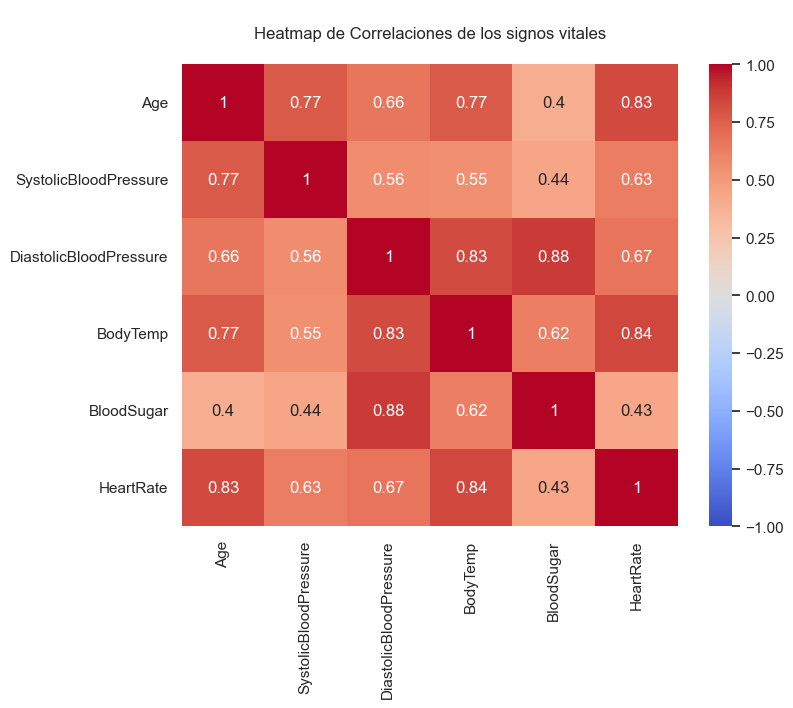

In [150]:
# 7. **Comprobar las correlaciones**:

corrMatrix = wearable_df2[['Age','SystolicBloodPressure', 'DiastolicBloodPressure', 'BodyTemp', 'BloodSugar', 'HeartRate']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("\nHeatmap de Correlaciones de los signos vitales\n")
plt.show()

#### Comprobación y validación del dataset sintético

##### Comprobación de propiedades estadísticas

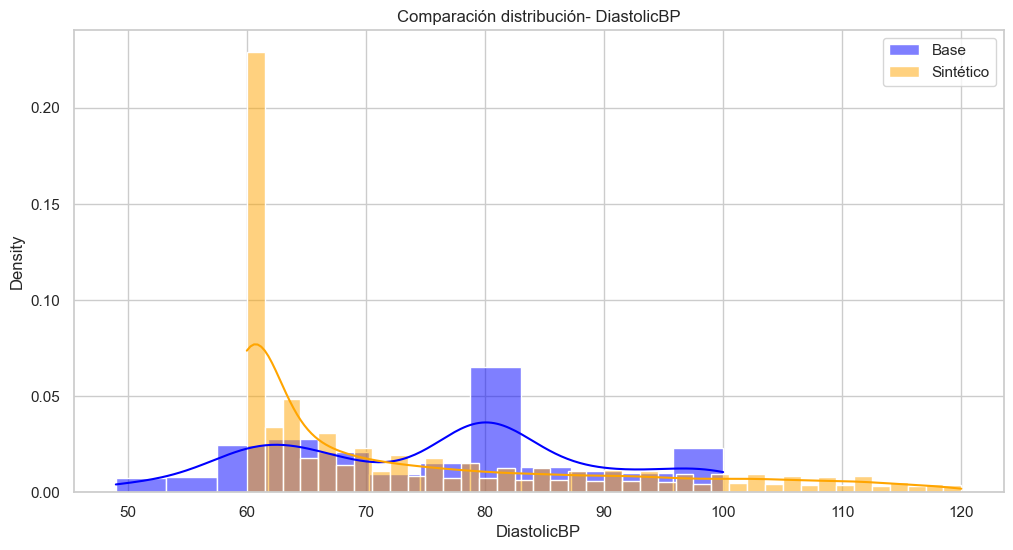

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable DiastolicBP

sns.histplot(df['DiastolicBP'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df2['DiastolicBloodPressure'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución- DiastolicBP')
plt.show()

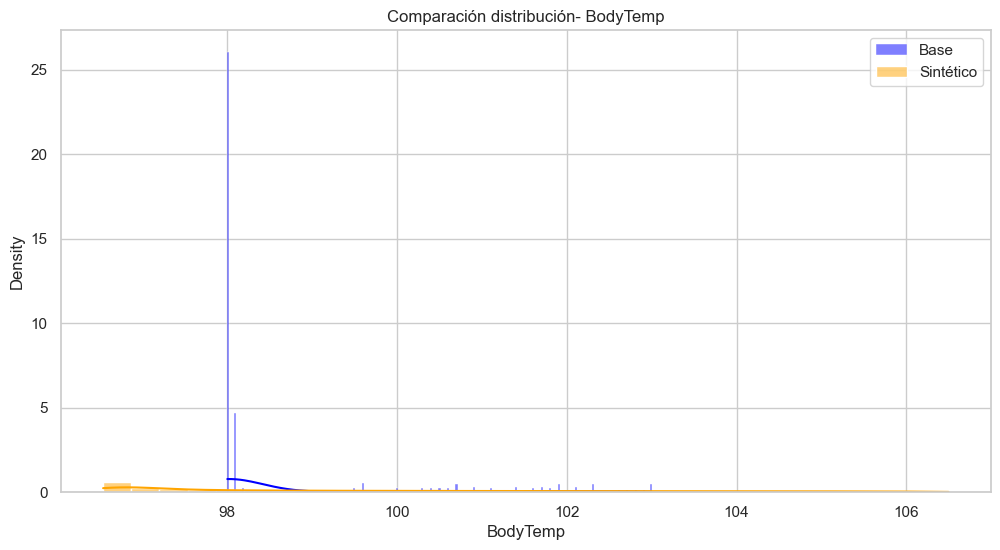

In [154]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable BodyTemp

sns.histplot(df['BodyTemp'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df2['BodyTemp'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución- BodyTemp')
plt.show()

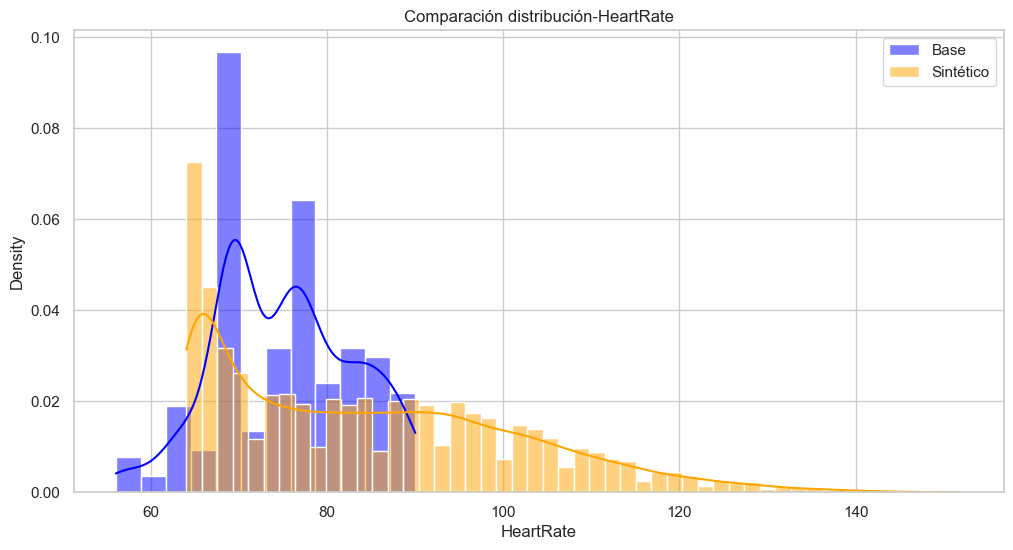

In [156]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable HeartRate

sns.histplot(df['HeartRate'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df2['HeartRate'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-HeartRate')
plt.show()

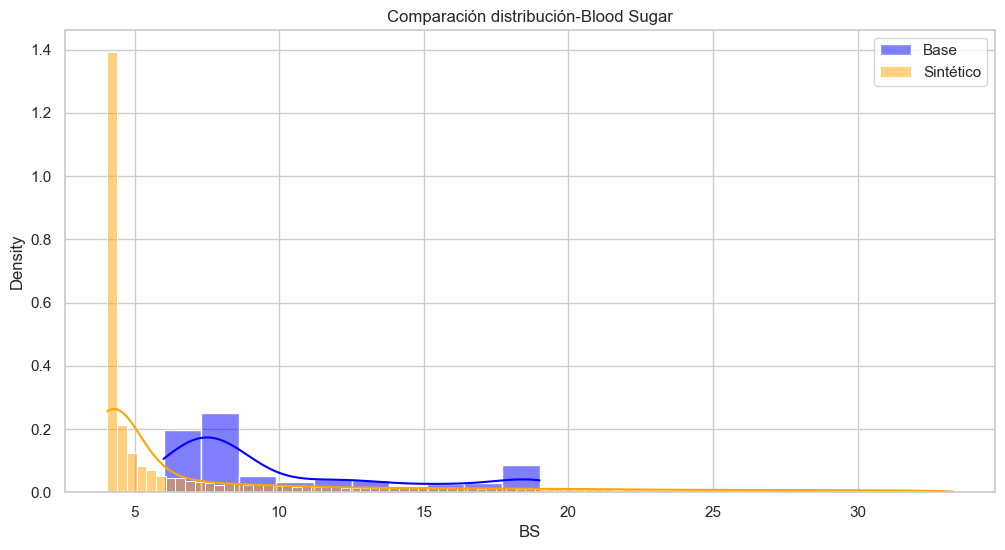

In [158]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable BloodSugar

sns.histplot(df['BS'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df2['BloodSugar'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-Blood Sugar')
plt.show()

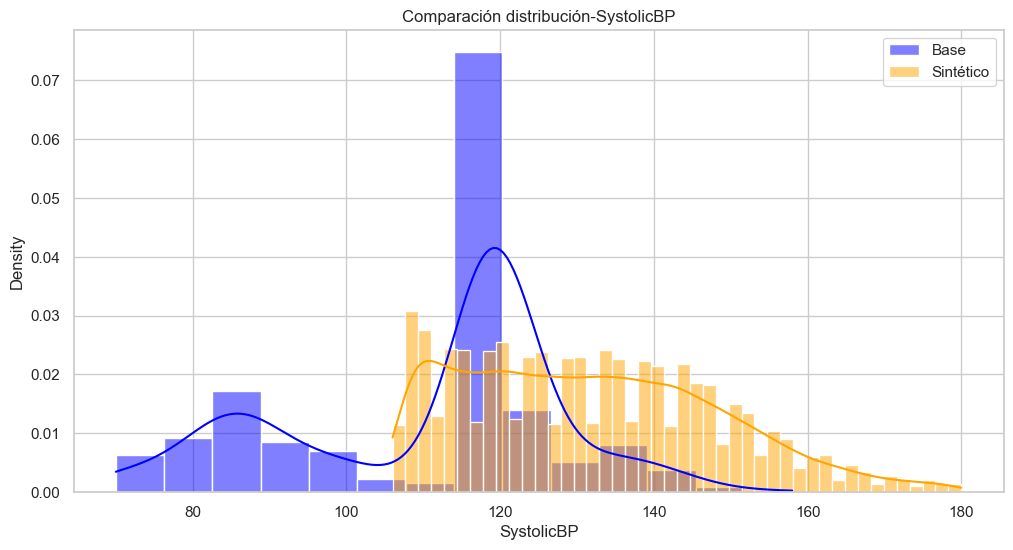

In [160]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable SystolicBP

sns.histplot(df['SystolicBP'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df2['SystolicBloodPressure'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-SystolicBP')
plt.show()

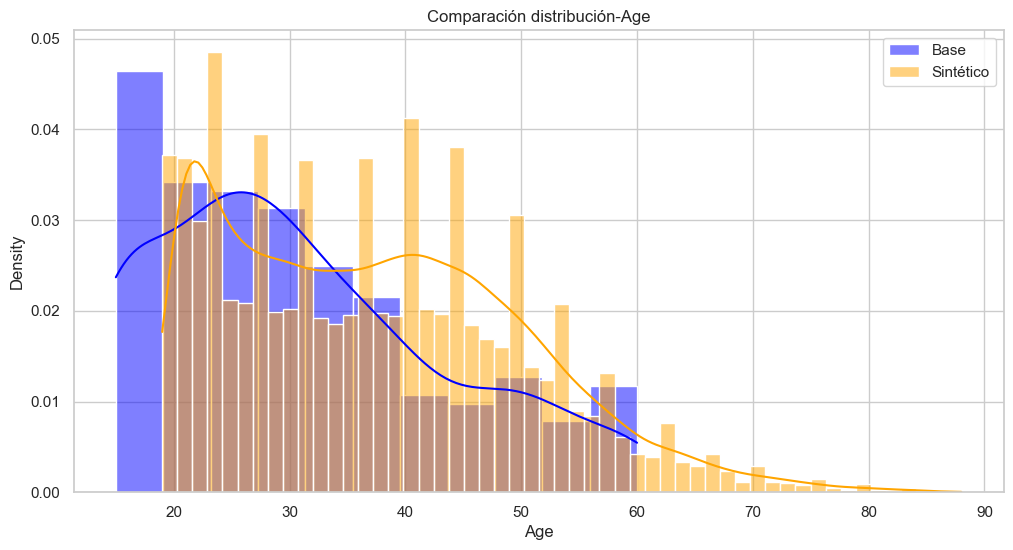

In [162]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable Age

sns.histplot(df['Age'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df2['Age'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-Age')
plt.show()

Como podemos comprobar, las distribuciones son muy distintas de forma visual. 
Aún asi, hay varias estrategias para mejorar la calidad de los datos que podemos seguir, 
ya que este es in porblema común a la hora de generar datos sintéticos. 

Antes de ajustar, vamos a entender cómo y dónde se diferencian nuestras distribuciones: 
Vamos a emplear el test Kolmogorov-Smirnov, mide las distancias entre distribuciones:
<ul>
    <li>ks_stat: representa la distancia máxima entre las distribuciones. Valores ceracnos a cero indican que las distribuciones son similares.</li>
    <li>p_value: indica si las dos distribuciones son estadísticamente diferentes. Un valor pequeño del p-value, significa que rechazamos la hipótesis nula (distribuciones significativamente diferentes).</li>
</ul>

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp


#Renombramos columnas dataframe sintetico

wearable_df2.rename(columns={'SystolicBloodPressure': 'SystolicBP', 'DiastolicBloodPressure': 'DiastolicBP', 'BloodSugar':'BS'}, inplace=True)
common_columns = [col for col in df.columns if col in wearable_df2.columns]

ks_results = {}
for column in common_columns:
    # Comprobar si la columna es numérica
    if pd.api.types.is_numeric_dtype(df[column]):
        
        # Kolmogorov-Smirnov Test
        ks_stat, p_value = ks_2samp(df[column], wearable_df2[column])
        ks_results[column] = {'KS Statistic': ks_stat, 'P-value': p_value}

# Convertir los resultados a un DataFrame para visualizarlos mejor
ks_results_df = pd.DataFrame(ks_results).T
print(ks_results_df)

             KS Statistic        P-value
Age              0.220439   1.959746e-21
SystolicBP       0.530348  2.152673e-129
DiastolicBP      0.253938   2.134967e-28
BS               0.645833  3.259871e-200
BodyTemp         0.398592   6.856787e-71
HeartRate        0.349157   5.252446e-54


Podemos observar que hay altas KS (gran diferencia) y p-values muy altos. 

## DATAFRAME UN SÓLO DATO POR USUARIO

In [168]:
wearable_df3= pd.read_csv('navigator-batch.csv')

In [170]:
wearable_df3.head()

,UserID,Age,Timestamp,DiastolicBloodPressure,SystolicBloodPressure,BloodSugar,BodyTemp,HeartRate
0,user131,25,18/07/2024 15:00:00,78,116,112,98.6,84
1,user132,38,18/07/2024 18:00:00,93,141,150,101.4,98
2,user133,32,18/07/2024 21:00:00,85,129,122,99.2,90
3,user134,46,19/07/2024 00:00:00,91,137,138,100.4,94
4,user135,27,19/07/2024 03:00:00,83,125,120,98.8,88


In [172]:
wearable_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UserID                  500 non-null    object 
 1   Age                     500 non-null    int64  
 2   Timestamp               500 non-null    object 
 3   DiastolicBloodPressure  500 non-null    int64  
 4   SystolicBloodPressure   500 non-null    int64  
 5   BloodSugar              500 non-null    int64  
 6   BodyTemp                500 non-null    float64
 7   HeartRate               500 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 31.4+ KB


Vamos a modificar los datos: 
<ul>
    <li>Renombramos las columnas como en el base. </li>
    <li>Convertimos las unidades de medida de Blood Sugar de mg/dl a mmol/l</li>
</ul>



In [174]:
#1. Renombramos las columnas
wearable_df3.rename(columns={'SystolicBloodPressure': 'SystolicBP', 'DiastolicBloodPressure': 'DiastolicBP', 'BloodSugar':'BS'}, inplace=True)

#2. Conversión de unidades : mg/dl a mmol/l
wearable_df3['BS'] = (wearable_df3['BS']/18)
wearable_df3['BS'] = wearable_df3['BS'].round(2)
wearable_df3.head()
    

,UserID,Age,Timestamp,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate
0,user131,25,18/07/2024 15:00:00,78,116,6.22,98.6,84
1,user132,38,18/07/2024 18:00:00,93,141,8.33,101.4,98
2,user133,32,18/07/2024 21:00:00,85,129,6.78,99.2,90
3,user134,46,19/07/2024 00:00:00,91,137,7.67,100.4,94
4,user135,27,19/07/2024 03:00:00,83,125,6.67,98.8,88


In [176]:
wearable_df3.describe()

,Age,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,44.968000,102.926000,137.728000,11.942600,104.501400,99.144000
std,16.979977,35.931583,20.739486,17.476532,5.333508,22.215001
min,19.000000,60.000000,105.000000,4.060000,96.500000,64.000000
25%,33.000000,83.000000,124.000000,6.390000,100.200000,84.000000
50%,41.000000,91.000000,134.000000,7.440000,103.800000,94.000000
75%,52.000000,108.000000,145.000000,8.500000,107.550000,109.250000
max,108.000000,256.000000,219.000000,118.780000,124.200000,168.000000


In [178]:
# 5. **Verificar duplicados**
# Verificar y eliminar filas duplicadas si es necesario
print(f"Número de filas duplicadas: {wearable_df3.duplicated().sum()}")

# 6. **Verificar rangos válidos para las variables**:
# Comprobar si los valores están dentro de los rangos fisiológicos razonables
verifica_rango(wearable_df3)

Número de filas duplicadas: 0
- Valores fuera del rango de SystolicBP:12

- Total valores de SystolicBP:500

- Valores validos de SystolicBP: 488

- Valores fuera del rango de DiastolicBP:93

- Total valores de DiastolicBP:500

- Valores validos de DiastolicBP: 407

- Valores fuera del rango de BodyTemp:155

- Total valores de BodyTemp:500

- Valores validos de BodyTemp: 345

- Valores fuera del rango de BS:32

- Total valores de BS:500

- Valores validos de BS: 468

- Valores fuera del rango de HeartRate:0

- Total valores de HeartRate:500

- Valores validos de HeartRate: 500



C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\507060035.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=wearable_df3['Age'], ax=axes[0], orient = "v", legend = False, linewidth = 1,
C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\507060035.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=wearable_df3['BodyTemp'], ax=axes[1], orient = "v", legend = False, linewidth = 1,
C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\507060035.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=wearable_df3['BS

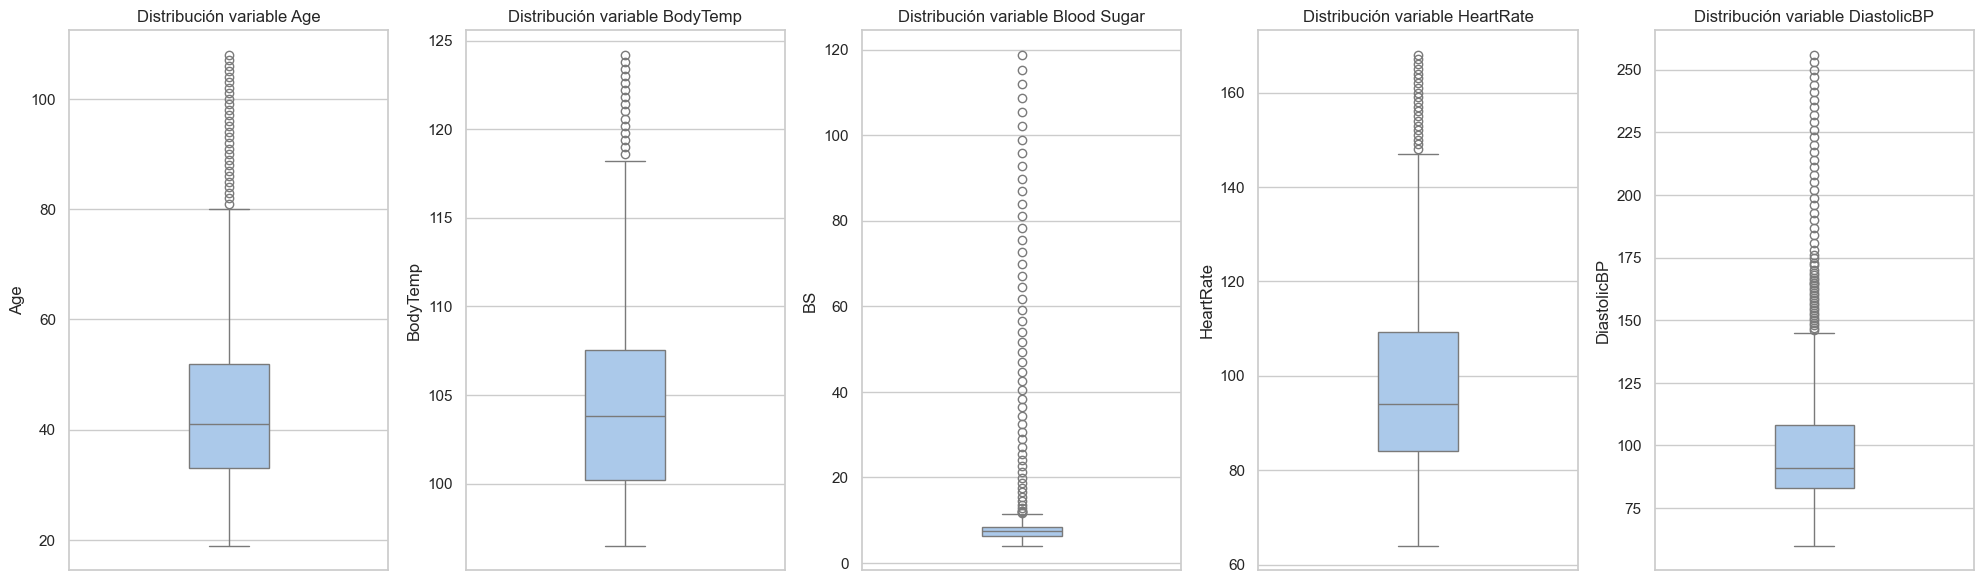

In [182]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

#Diagrama columna 'Age'
sns.boxplot(y=wearable_df3['Age'], ax=axes[0], orient = "v", legend = False, linewidth = 1,
           native_scale=True, width = .25, palette = "pastel", color = '#a1c9f4')
axes[0].set_title('Distribución variable Age')

#Diagrama BodyTemp
sns.boxplot(y=wearable_df3['BodyTemp'], ax=axes[1], orient = "v", legend = False, linewidth = 1,
            native_scale=True, width = .25, palette = "pastel", color = '#8de5a1')
axes[1].set_title('Distribución variable BodyTemp')

# Boxplot para BS (Blood Sugar)
sns.boxplot(y=wearable_df3['BS'], ax=axes[2],  orient = "v", legend = False, linewidth = 1,native_scale=True, 
            width = .25, palette = "pastel", color = '#ff9f9b')
axes[2].set_title('Distribución variable Blood Sugar')

# Boxplot para HeartRate
sns.boxplot(y=wearable_df3['HeartRate'], ax=axes[3], orient = "v", legend = False, linewidth = 1,
            native_scale=True, width = .25, palette = "pastel", color = '#d0bbff')
axes[3].set_title('Distribución variable HeartRate')

# Boxplot para SystolicBP
sns.boxplot(y=wearable_df3['DiastolicBP'], ax= axes[4], orient = "v", legend = False, linewidth = 1,
           native_scale=True, width = .25, palette = "pastel",color = '#fffea3')
axes[4].set_title('Distribución variable DiastolicBP')

plt.tight_layout()
plt.show()

A diferencia del resto de opciones, este presente dataset tiene muchos outliers, por
lo que vamos a eliminarlos. 

In [184]:
def elimina_outliers(dataframe):
    rangos= {
        'Age': (15, 60),
        'BodyTemp': (82, 106.5),  
        'BS': (2.2, 33.3),  
        'SystolicBP': (70, 180),  
        'DiastolicBP': (40, 120)  
    }
    for columna, (min_val, max_val) in rangos.items():
        if columna in dataframe.columns:
            dataframe = dataframe[(dataframe[columna] >= min_val) & (dataframe[columna] <= max_val)]
    return dataframe


In [186]:
data = elimina_outliers(wearable_df3)
verifica_rango(wearable_df3)

- Valores fuera del rango de SystolicBP:12

- Total valores de SystolicBP:500

- Valores validos de SystolicBP: 488

- Valores fuera del rango de DiastolicBP:93

- Total valores de DiastolicBP:500

- Valores validos de DiastolicBP: 407

- Valores fuera del rango de BodyTemp:155

- Total valores de BodyTemp:500

- Valores validos de BodyTemp: 345

- Valores fuera del rango de BS:32

- Total valores de BS:500

- Valores validos de BS: 468

- Valores fuera del rango de HeartRate:0

- Total valores de HeartRate:500

- Valores validos de HeartRate: 500



Comprobamos que correlaciones hay entre las variables y si coinciden con el dataset base:

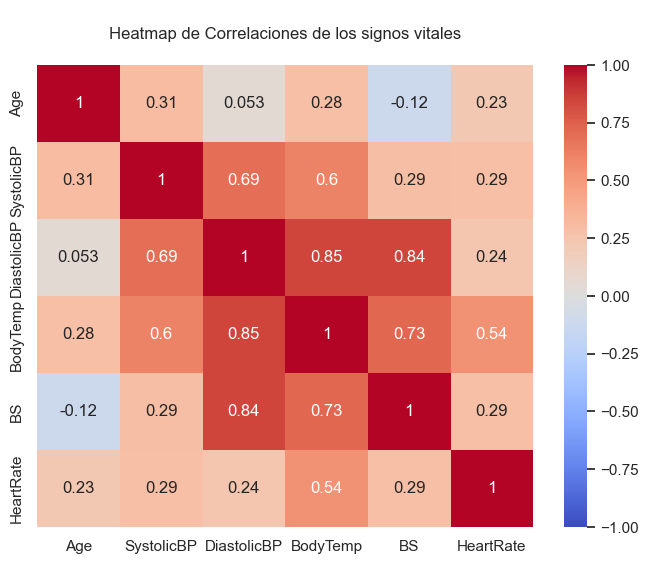

In [188]:
correlation_matrix = wearable_df3[['Age','SystolicBP', 'DiastolicBP', 'BodyTemp', 'BS', 'HeartRate']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("\nHeatmap de Correlaciones de los signos vitales\n")
plt.show()

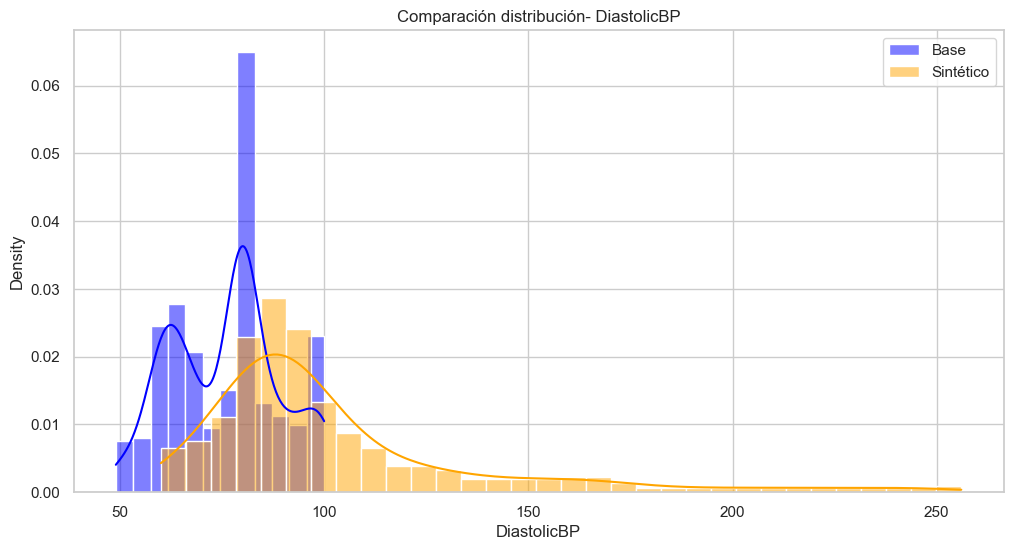

In [190]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable DiastolicBP

sns.histplot(df['DiastolicBP'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df3['DiastolicBP'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución- DiastolicBP')
plt.show()

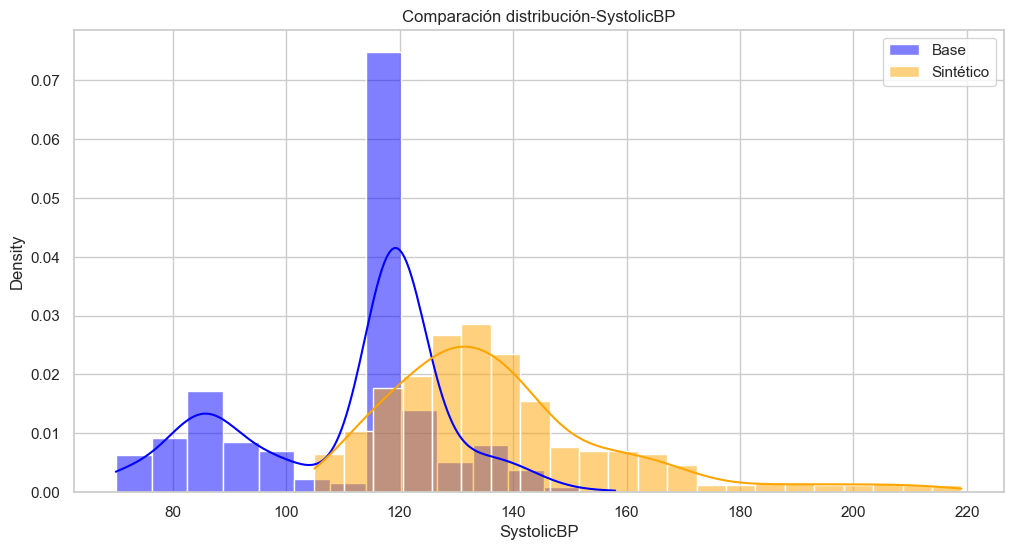

In [192]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable SystolicBP

sns.histplot(df['SystolicBP'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df3['SystolicBP'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-SystolicBP')
plt.show()

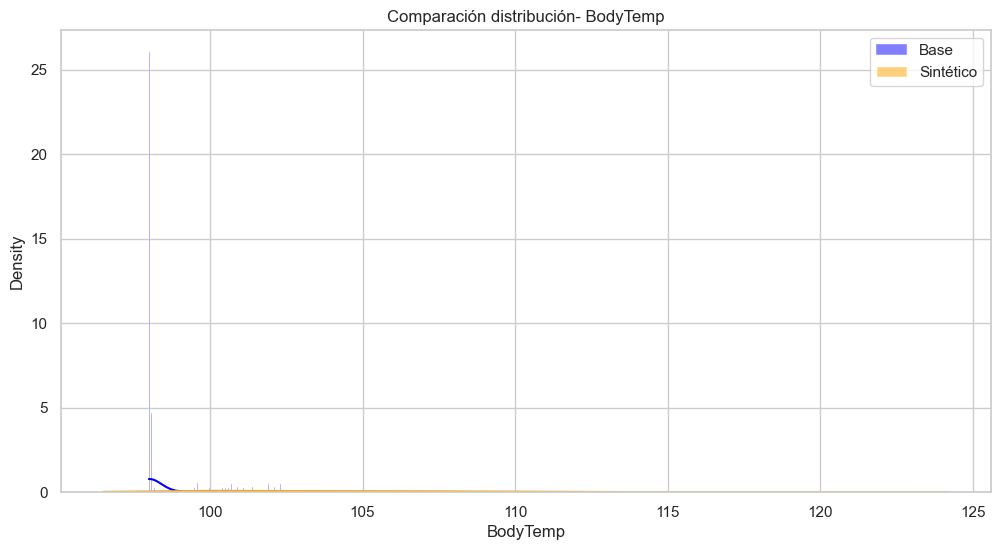

In [194]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable BodyTemp

sns.histplot(df['BodyTemp'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df3['BodyTemp'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución- BodyTemp')
plt.show()

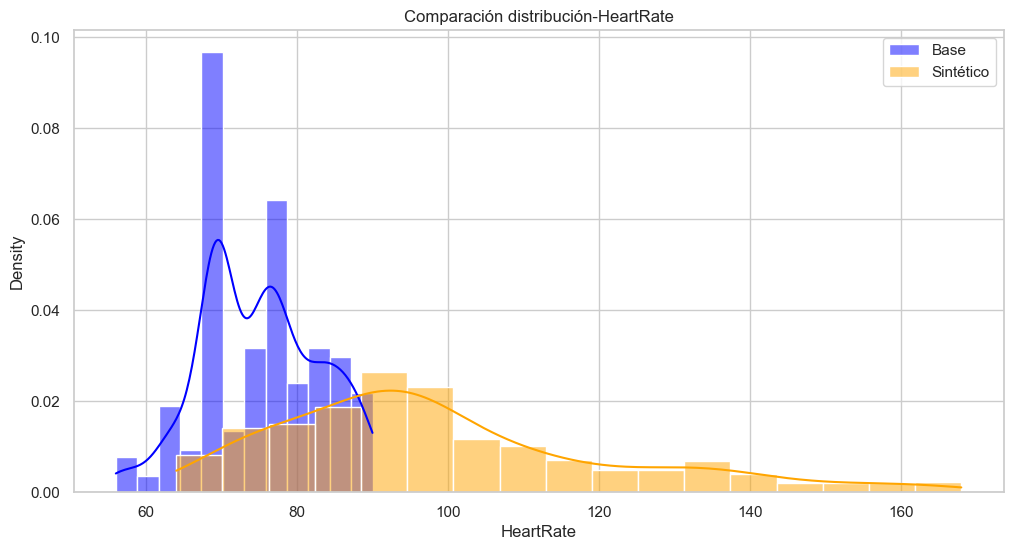

In [196]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable HeartRate

sns.histplot(df['HeartRate'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df3['HeartRate'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-HeartRate')
plt.show()

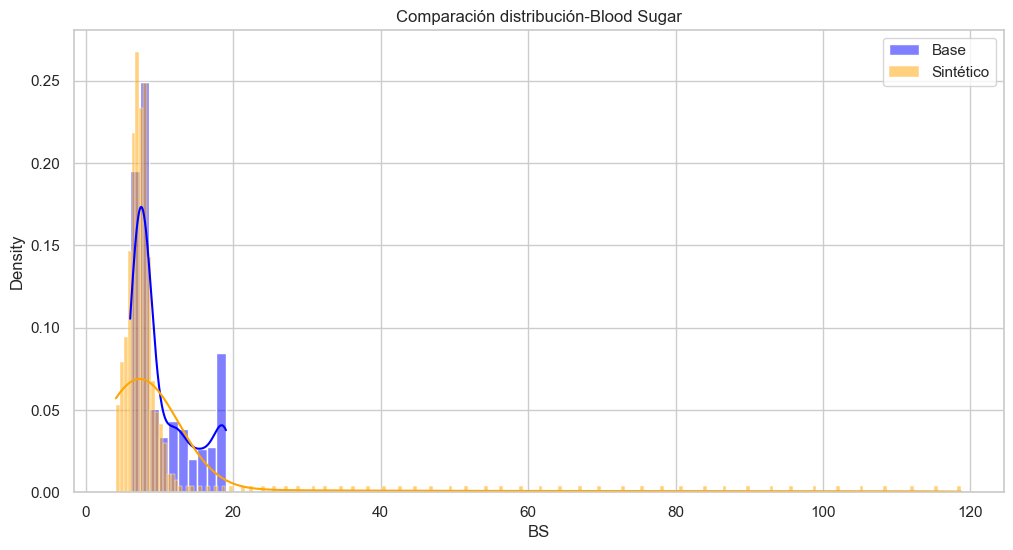

In [198]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable BloodSugar

sns.histplot(df['BS'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df3['BS'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-Blood Sugar')
plt.show()

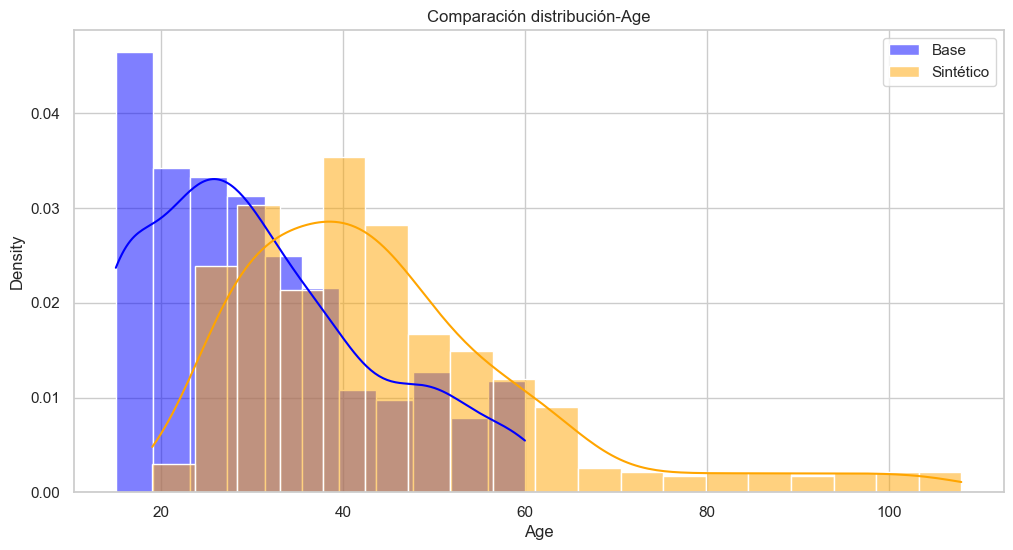

In [200]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable Age

sns.histplot(df['Age'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df3['Age'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-Age')
plt.show()

A diferencia de las otras dos opciones, cubren practicamente todo el rango, aunque los valores salgan con menos frecuencia. 
Pero no nos preocupa mucho porque en el siguiente apartado nuestro objetivo es aumentar el número de datos registrados por usuario al día, 
y luego después al mes. Con lo que cabe esperar que la densidad en las gráficas aumentará, pero al menos no solo alberga una zona. 

## ANÁLISIS DEL PROBLEMA ACTUAL: DESCARTAR O NO EL DATASET GENERADO

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp


#Renombramos columnas dataframe sintetico

common_columns = [col for col in df.columns if col in wearable_df3.columns]

ksResults = {}
for column in common_columns:
    # Comprobar si la columna es numérica
    if pd.api.types.is_numeric_dtype(df[column]):
        
        # Kolmogorov-Smirnov Test
        ks_stat, p_value = ks_2samp(df[column], wearable_df3[column])
        ksResults[column] = {'KS Statistic': ks_stat, 'P-value': p_value}

# Convertir los resultados a un DataFrame para visualizarlos mejor
ksResults_data = pd.DataFrame(ks_results).T
print(ksResults_data)

             KS Statistic        P-value
Age              0.220439   1.959746e-21
SystolicBP       0.530348  2.152673e-129
DiastolicBP      0.253938   2.134967e-28
BS               0.645833  3.259871e-200
BodyTemp         0.398592   6.856787e-71
HeartRate        0.349157   5.252446e-54


<ol>
    <li>Test Kolmogorov-Smirnov: los valores del p-value son muy bajos, lo que bindica que las distribuciones entre el dataset base y el sintético son muy diferentes.</li>
    <li>Histograma / KDE : observando los gráficos vemos que las distribuciones son significativamente distintas, por lo que el dataset sintético no representa con precisión algunas de las características del dataset base. Sin embargo, es importante notar que el dataset sintético cubre el rango fisiológico.</li>
    <li>Extensión del dataset sintético: el objetivo es simular varias medidas diarias para cada usuario, y esperamos que la densidad de los valores aumente y las distribuciones se acercquen más a las reales, aunque no es seguro esperar que las distribuciones finales sean idénticas.</li>
</ol>

Otras consideraciones:
El propóstio del dataset es para que nuestro modelo prediga los riesgos de una mujer embarazada de padecer tener un embarazo de riesgo o de presentar alguna complicación durante la gestación. Lo importante es que los datos sintéticos sean fisológicamente razonables y capture relaciones clave entre variables, no necesariamente necesitammos que sean idénticas las correlaciones, pero sí consistentes con la fisiología humana. 

Es por ello, que al cubrir más valores del rango, introduce menor sesgo, y tras la extensión se espera aumentar la densidad, acercándose más a los datos reales. 


## INTENTO 4 WEARABLE, MENOS USUARIOS, MÁS DÍAS Y 3 CAPTURADAS AL DÍA

Volvemos a generar más datos siendo más exigentes en que siga las características, patrones temporales y correlacione entre variables del dataset de Maternal Health Risk Data Set atemporal

In [204]:
wearable_df4= pd.read_csv('user-wearable.csv')

In [207]:
wearable_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    500 non-null    object 
 1   user_id      500 non-null    object 
 2   age          500 non-null    int64  
 3   SystolicBP   500 non-null    int64  
 4   DiastolicBP  500 non-null    int64  
 5   BodyTemp     500 non-null    float64
 6   BS           500 non-null    float64
 7   HeartRate    500 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 31.4+ KB


In [209]:
wearable_df4.head()

,timestamp,user_id,age,SystolicBP,DiastolicBP,BodyTemp,BS,HeartRate
0,08/09/23 08:00:00,user_500,29,185,124,95.9,30.55,128
1,08/09/23 15:00:00,user_500,29,201,129,99.5,34.11,140
2,08/09/23 21:00:00,user_500,29,191,125,97.1,31.88,136
3,09/09/23 08:00:00,user_500,29,189,123,96.3,30.22,134
4,09/09/23 15:00:00,user_500,29,203,127,99.8,33.55,142


In [211]:
wearable_df4.describe()

,age,SystolicBP,DiastolicBP,BodyTemp,BS,HeartRate
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000
mean,28.382000,175.362000,116.722000,104.385600,8.57526,82.732000
std,5.376047,19.815152,20.456629,6.524917,10.00166,23.665932
min,22.000000,139.000000,82.000000,94.200000,0.00000,58.000000
25%,23.000000,160.000000,101.000000,99.400000,3.54000,68.000000
50%,29.000000,173.000000,110.000000,102.700000,4.43000,77.000000
75%,34.000000,188.250000,131.000000,108.425000,9.44000,84.000000
max,38.000000,239.000000,184.000000,125.300000,53.22000,182.000000


In [215]:
#1. Renombramos las columnas
wearable_df4.rename(columns = {'age':'Age'}, inplace=True)

#2. Mirar nº de filas duplicadas
print(f"\nNúmero de filas duplicadas: {data.duplicated().sum()}\n")

# 3. **Verificar rangos válidos para las variables**:
# Comprobar si los valores están dentro de los rangos fisiológicos razonables y eliminarlos
verifica_rango(wearable_df4)
elimina_outliers(wearable_df4)



Número de filas duplicadas: 0

- Valores fuera del rango de SystolicBP:61

- Total valores de SystolicBP:500

- Valores validos de SystolicBP: 439

- Valores fuera del rango de DiastolicBP:182

- Total valores de DiastolicBP:500

- Valores validos de DiastolicBP: 318

- Valores fuera del rango de BodyTemp:165

- Total valores de BodyTemp:500

- Valores validos de BodyTemp: 335

- Valores fuera del rango de BS:42

- Total valores de BS:500

- Valores validos de BS: 458

- Valores fuera del rango de HeartRate:0

- Total valores de HeartRate:500

- Valores validos de HeartRate: 500



,timestamp,user_id,Age,SystolicBP,DiastolicBP,BodyTemp,BS,HeartRate
35,23/11/23 08:00:00,user_151,22,145,93,96.3,5.56,90
36,23/11/23 15:00:00,user_151,22,153,101,98.5,6.78,92
37,23/11/23 21:00:00,user_151,22,147,99,97.4,6.22,90
38,24/11/23 08:00:00,user_151,22,149,100,98.1,6.44,91
39,24/11/23 15:00:00,user_151,22,157,102,100.4,7.56,94
...,...,...,...,...,...,...,...,...
420,26/07/25 08:00:00,user_151,23,164,118,94.2,3.51,66
490,26/07/24 08:00:00,user_100,37,147,110,96.3,3.23,58
491,26/07/24 15:00:00,user_100,37,157,118,98.5,3.49,60
492,26/07/24 21:00:00,user_100,37,149,114,97.1,3.27,59


C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\1641177670.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=wearable_df4['Age'], ax=axes[0], orient = "v", legend = False, linewidth = 1,
C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\1641177670.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=wearable_df4['BodyTemp'], ax=axes[1], orient = "v", legend = False, linewidth = 1,
C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\1641177670.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=wearable_df4[

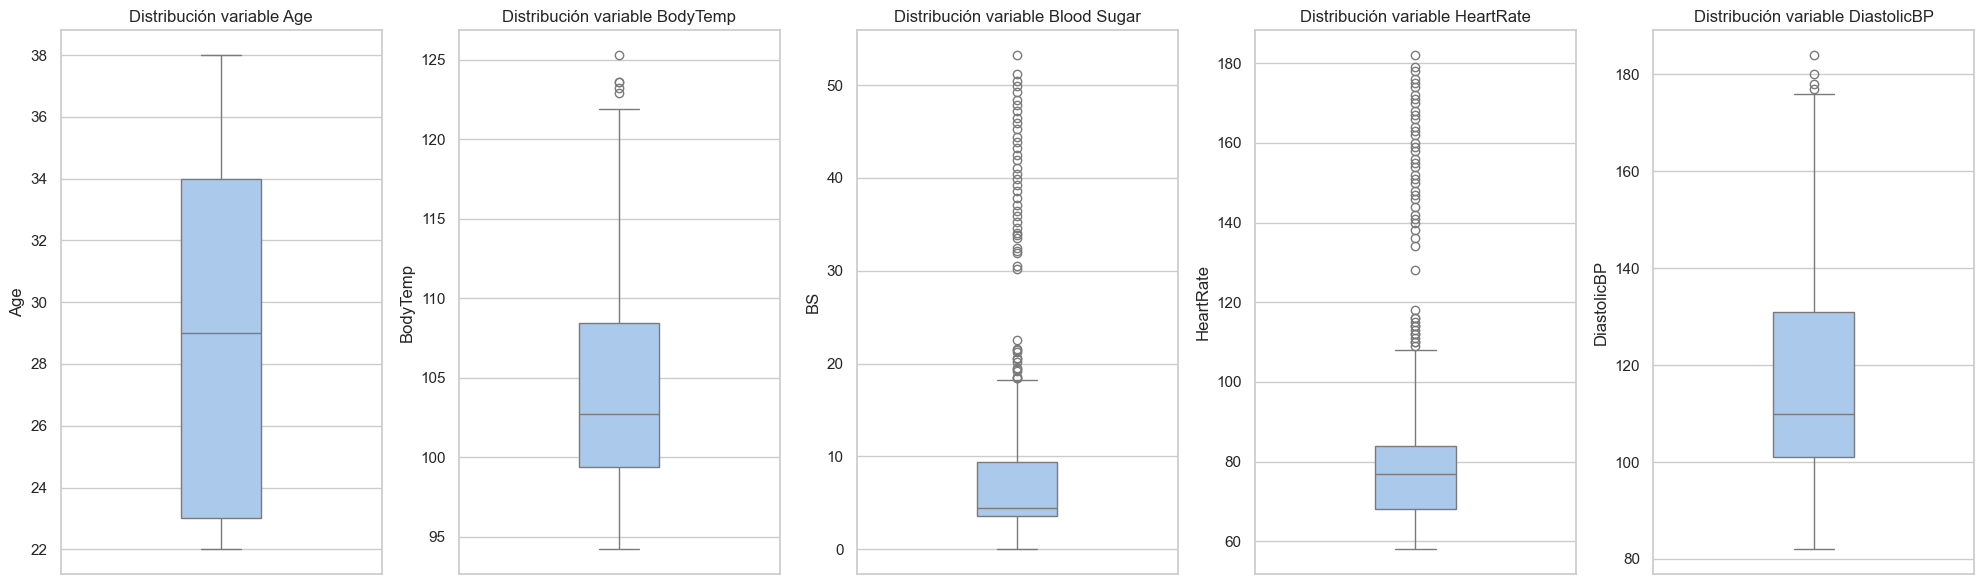

In [217]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

#Diagrama columna 'Age'
sns.boxplot(y=wearable_df4['Age'], ax=axes[0], orient = "v", legend = False, linewidth = 1,
           native_scale=True, width = .25, palette = "pastel", color = '#a1c9f4')
axes[0].set_title('Distribución variable Age')

#Diagrama BodyTemp
sns.boxplot(y=wearable_df4['BodyTemp'], ax=axes[1], orient = "v", legend = False, linewidth = 1,
            native_scale=True, width = .25, palette = "pastel", color = '#8de5a1')
axes[1].set_title('Distribución variable BodyTemp')

# Boxplot para BS (Blood Sugar)
sns.boxplot(y=wearable_df4['BS'], ax=axes[2],  orient = "v", legend = False, linewidth = 1,native_scale=True, 
            width = .25, palette = "pastel", color = '#ff9f9b')
axes[2].set_title('Distribución variable Blood Sugar')

# Boxplot para HeartRate
sns.boxplot(y=wearable_df4['HeartRate'], ax=axes[3], orient = "v", legend = False, linewidth = 1,
            native_scale=True, width = .25, palette = "pastel", color = '#d0bbff')
axes[3].set_title('Distribución variable HeartRate')

# Boxplot para SystolicBP
sns.boxplot(y=wearable_df4['DiastolicBP'], ax= axes[4], orient = "v", legend = False, linewidth = 1,
           native_scale=True, width = .25, palette = "pastel",color = '#fffea3')
axes[4].set_title('Distribución variable DiastolicBP')

plt.tight_layout()
plt.show()

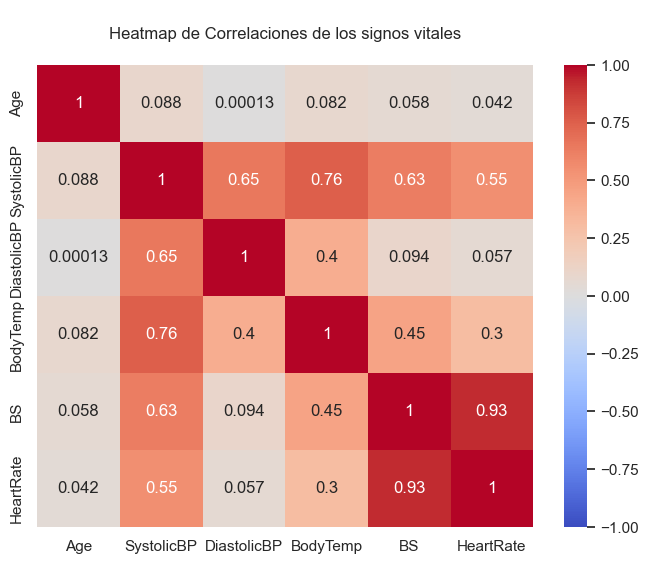

In [219]:
corrMatWearable = wearable_df4[['Age','SystolicBP', 'DiastolicBP', 'BodyTemp', 'BS', 'HeartRate']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corrMatWearable, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("\nHeatmap de Correlaciones de los signos vitales\n")
plt.show()

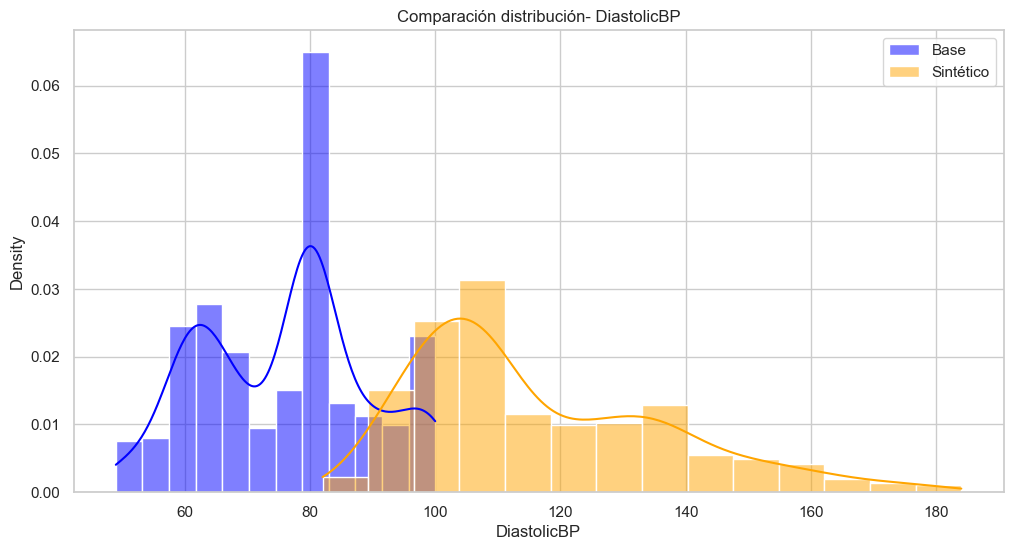

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable DiastolicBP

sns.histplot(df['DiastolicBP'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df4['DiastolicBP'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución- DiastolicBP')
plt.show()

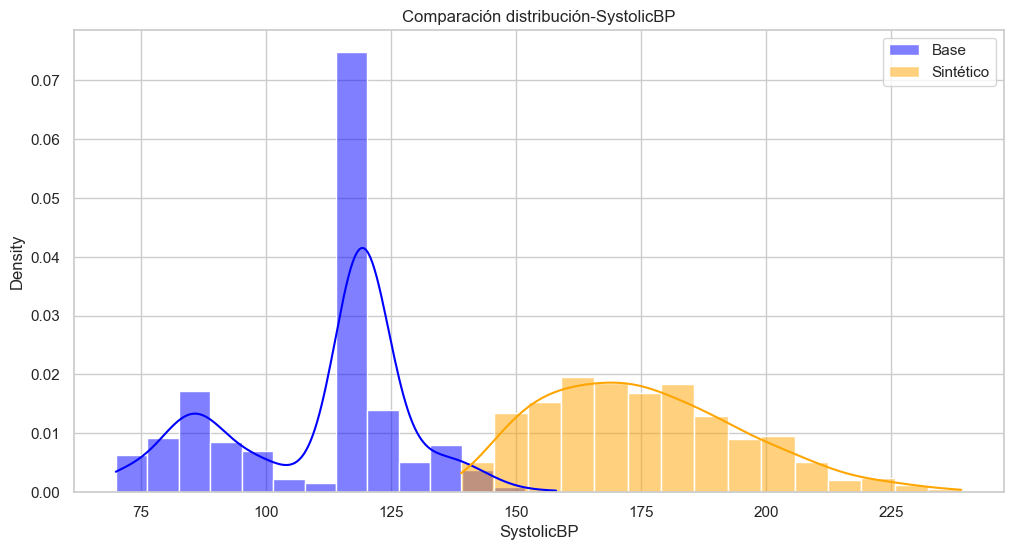

In [223]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable SystolicBP

sns.histplot(df['SystolicBP'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df4['SystolicBP'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-SystolicBP')
plt.show()

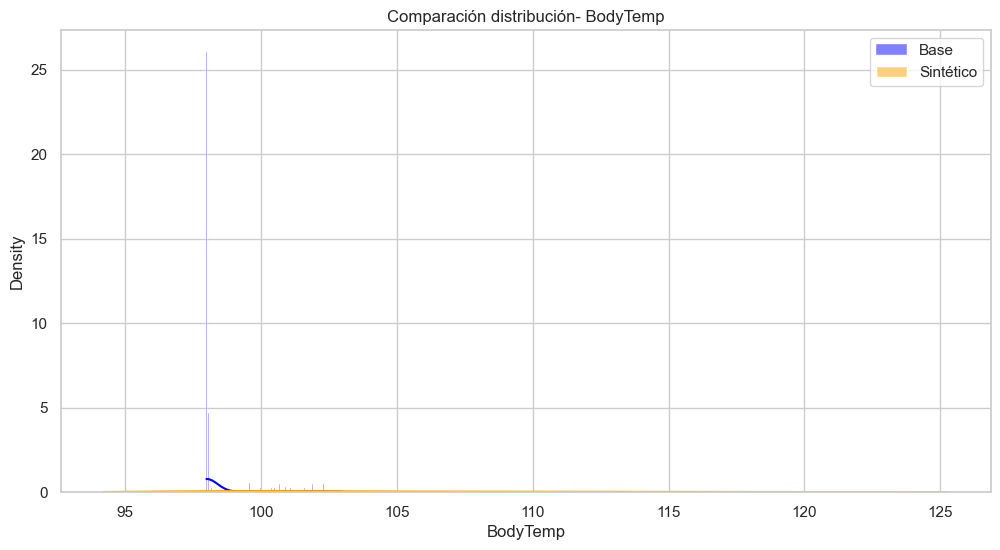

In [225]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable BodyTemp

sns.histplot(df['BodyTemp'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df4['BodyTemp'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución- BodyTemp')
plt.show()

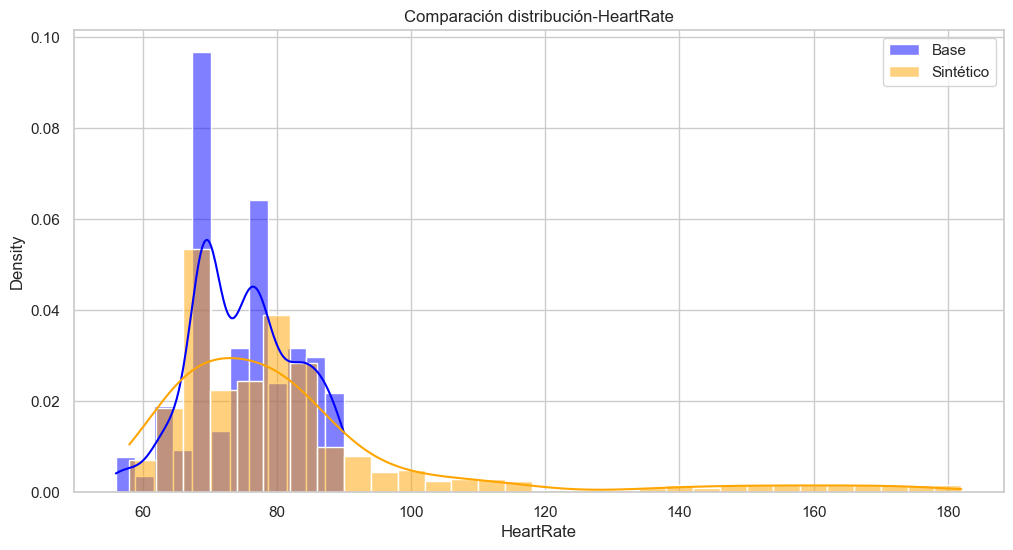

In [227]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable HeartRate

sns.histplot(df['HeartRate'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df4['HeartRate'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-HeartRate')
plt.show()

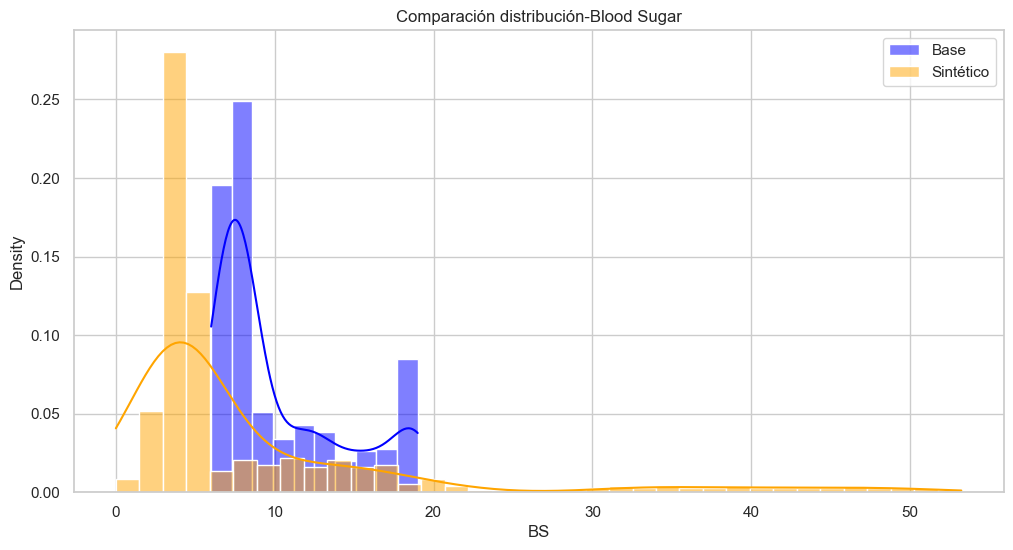

In [229]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable BloodSugar

sns.histplot(df['BS'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df4['BS'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-Blood Sugar')
plt.show()

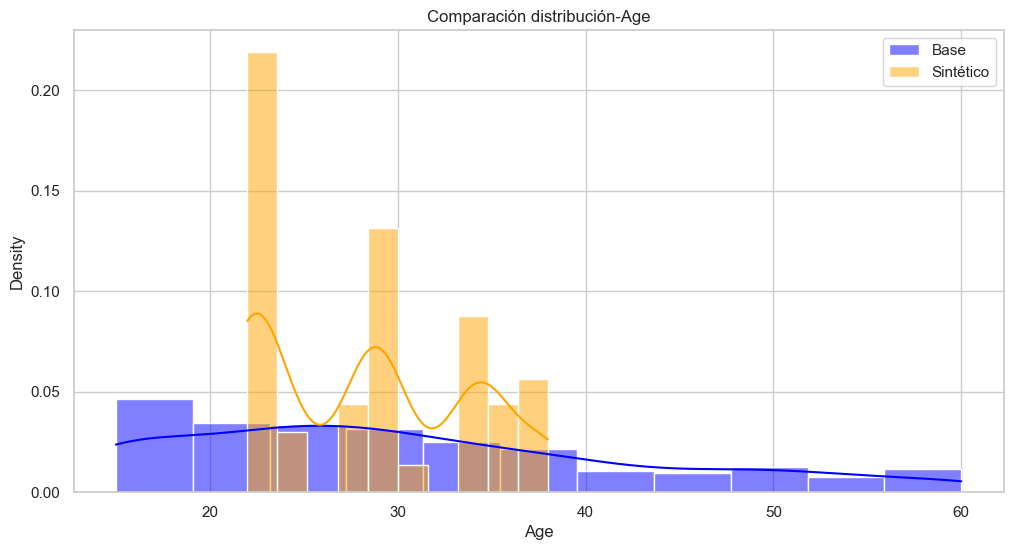

In [231]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable Age

sns.histplot(df['Age'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df4['Age'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-Age')
plt.show()

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp


#Renombramos columnas dataframe sintetico

common_columns = [col for col in df.columns if col in wearable_df4.columns]

ksResults = {}
for column in common_columns:
    # Comprobar si la columna es numérica
    if pd.api.types.is_numeric_dtype(df[column]):
        
        # Kolmogorov-Smirnov Test
        ks_stat, p_value = ks_2samp(df[column], wearable_df4[column])
        ksResults[column] = {'KS Statistic': ks_stat, 'P-value': p_value}

# Convertir los resultados a un DataFrame para visualizarlos mejor
ksResultsWearable = pd.DataFrame(ksResults).T
print(ksResultsWearable)

             KS Statistic        P-value
Age                 0.254   1.416980e-14
SystolicBP          0.976  1.445746e-272
DiastolicBP         0.822  7.912187e-171
BS                  0.690  5.199317e-114
BodyTemp            0.608   1.832779e-86
HeartRate           0.172   7.102426e-07


### INTENTO 5

In [238]:
import pandas as pd
wearable_df5= pd.read_csv('user_wearable2.csv')

In [240]:
wearable_df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    500 non-null    object 
 1   user_id      500 non-null    object 
 2   age          500 non-null    int64  
 3   SystolicBP   500 non-null    int64  
 4   DiastolicBP  500 non-null    int64  
 5   BodyTemp     500 non-null    float64
 6   BS           500 non-null    float64
 7   HeartRate    500 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 31.4+ KB


In [242]:
wearable_df5.head()

,timestamp,user_id,age,SystolicBP,DiastolicBP,BodyTemp,BS,HeartRate
0,24/07/24 08:00:00,user_1001,28,110,70,98.1,105.0,65
1,24/07/24 11:00:00,user_1001,28,112,72,98.0,108.0,66
2,24/07/24 14:00:00,user_1001,28,114,74,97.9,111.0,67
3,24/07/24 17:00:00,user_1001,28,116,76,97.8,114.0,68
4,24/07/24 20:00:00,user_1001,28,118,78,97.7,117.0,69


In [244]:
#1. Renombramos las columnas
wearable_df5.rename(columns = {'age':'Age'}, inplace=True)

#2. Mirar nº de filas duplicadas
print(f"\nNúmero de filas duplicadas: {wearable_df5.duplicated().sum()}\n")

# 3. **Verificar rangos válidos para las variables**:
# Comprobar si los valores están dentro de los rangos fisiológicos razonables y eliminarlos
verifica_rango(wearable_df5)
elimina_outliers(wearable_df5)


Número de filas duplicadas: 0

- Valores fuera del rango de SystolicBP:0

- Total valores de SystolicBP:500

- Valores validos de SystolicBP: 500

- Valores fuera del rango de DiastolicBP:28

- Total valores de DiastolicBP:500

- Valores validos de DiastolicBP: 472

- Valores fuera del rango de BodyTemp:0

- Total valores de BodyTemp:500

- Valores validos de BodyTemp: 500

- Valores fuera del rango de BS:500

- Total valores de BS:500

- Valores validos de BS: 0

- Valores fuera del rango de HeartRate:0

- Total valores de HeartRate:500

- Valores validos de HeartRate: 500



,timestamp,user_id,Age,SystolicBP,DiastolicBP,BodyTemp,BS,HeartRate


C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\260470659.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=wearable_df5['Age'], ax=axes[0], orient = "v", legend = False, linewidth = 1,
C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\260470659.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=wearable_df5['BodyTemp'], ax=axes[1], orient = "v", legend = False, linewidth = 1,
C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\260470659.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=wearable_df5['BS

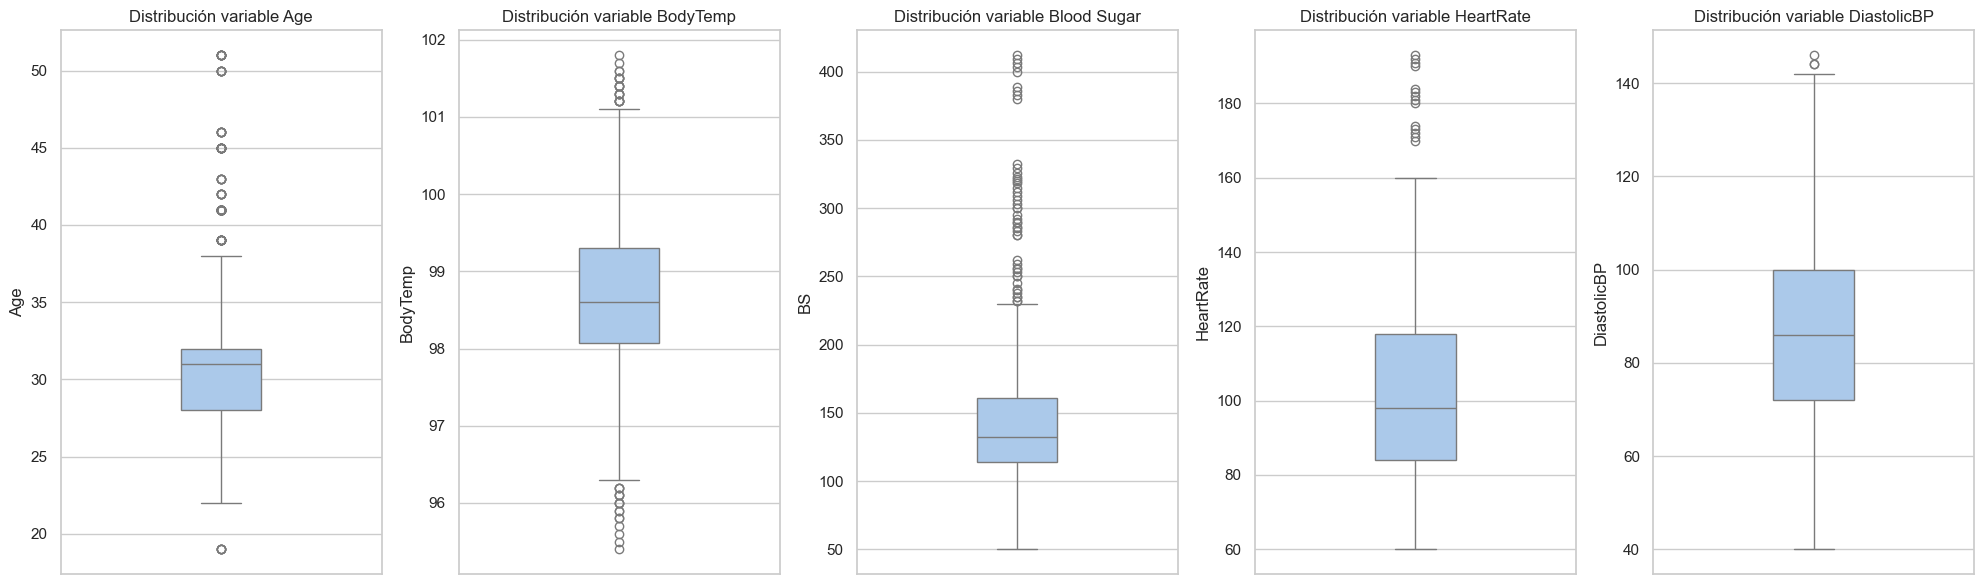

In [246]:
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

#Diagrama columna 'Age'
sns.boxplot(y=wearable_df5['Age'], ax=axes[0], orient = "v", legend = False, linewidth = 1,
           native_scale=True, width = .25, palette = "pastel", color = '#a1c9f4')
axes[0].set_title('Distribución variable Age')

#Diagrama BodyTemp
sns.boxplot(y=wearable_df5['BodyTemp'], ax=axes[1], orient = "v", legend = False, linewidth = 1,
            native_scale=True, width = .25, palette = "pastel", color = '#8de5a1')
axes[1].set_title('Distribución variable BodyTemp')

# Boxplot para BS (Blood Sugar)
sns.boxplot(y=wearable_df5['BS'], ax=axes[2],  orient = "v", legend = False, linewidth = 1,native_scale=True, 
            width = .25, palette = "pastel", color = '#ff9f9b')
axes[2].set_title('Distribución variable Blood Sugar')

# Boxplot para HeartRate
sns.boxplot(y=wearable_df5['HeartRate'], ax=axes[3], orient = "v", legend = False, linewidth = 1,
            native_scale=True, width = .25, palette = "pastel", color = '#d0bbff')
axes[3].set_title('Distribución variable HeartRate')

# Boxplot para SystolicBP
sns.boxplot(y=wearable_df5['DiastolicBP'], ax= axes[4], orient = "v", legend = False, linewidth = 1,
           native_scale=True, width = .25, palette = "pastel",color = '#fffea3')
axes[4].set_title('Distribución variable DiastolicBP')

plt.tight_layout()
plt.show()

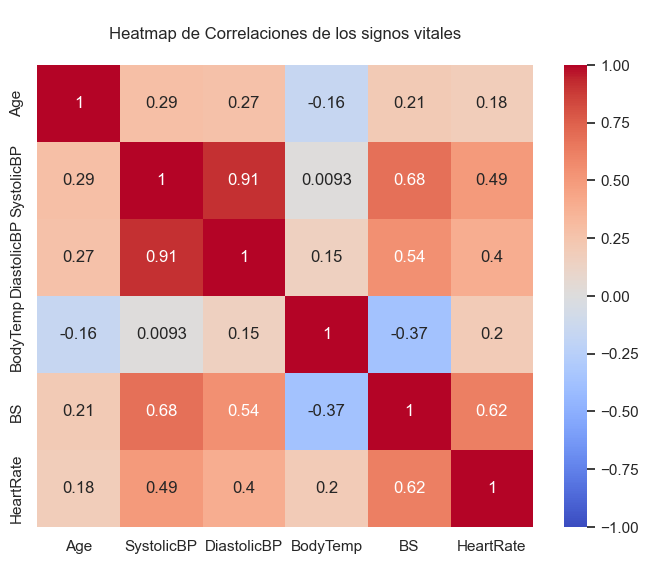

In [248]:
corrMatWearable = wearable_df5[['Age','SystolicBP', 'DiastolicBP', 'BodyTemp', 'BS', 'HeartRate']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corrMatWearable, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("\nHeatmap de Correlaciones de los signos vitales\n")
plt.show()

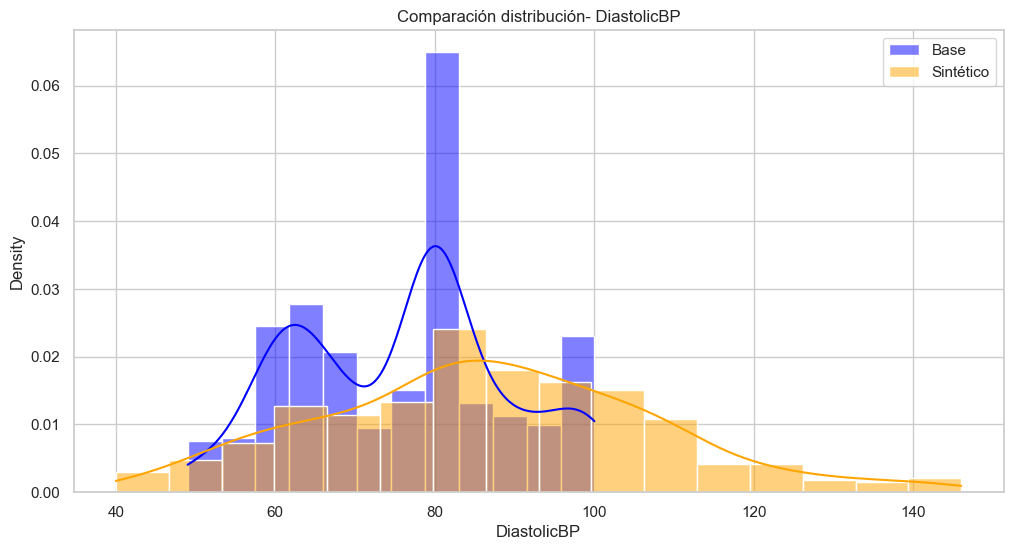

In [250]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable DiastolicBP

sns.histplot(df['DiastolicBP'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df5['DiastolicBP'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución- DiastolicBP')
plt.show()

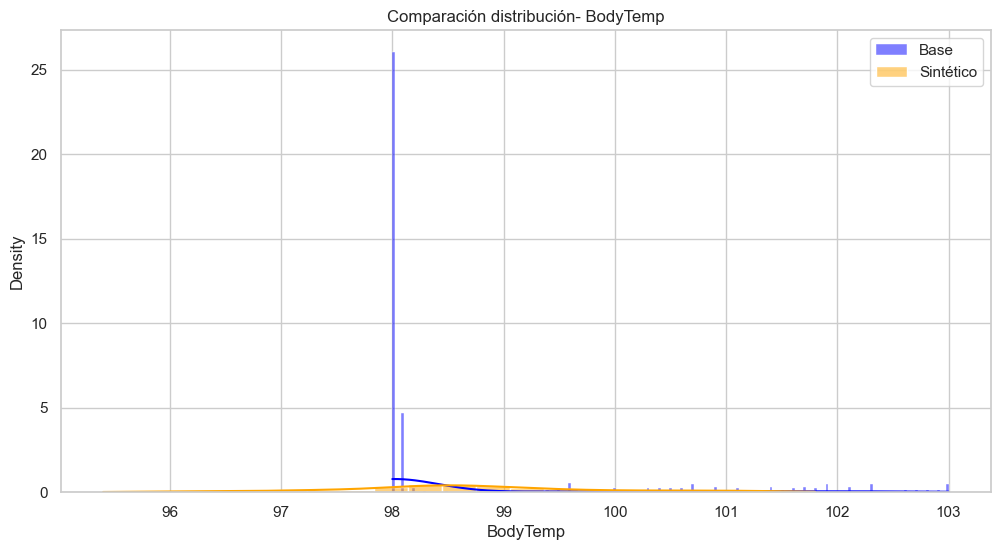

In [252]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable BodyTemp

sns.histplot(df['BodyTemp'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df5['BodyTemp'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución- BodyTemp')
plt.show()

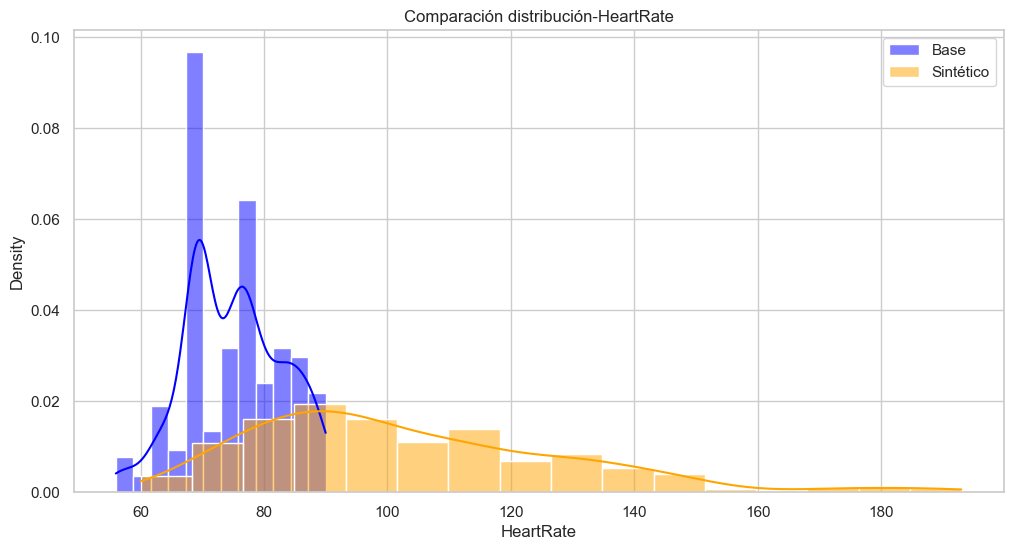

In [254]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable HeartRate

sns.histplot(df['HeartRate'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df5['HeartRate'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-HeartRate')
plt.show()

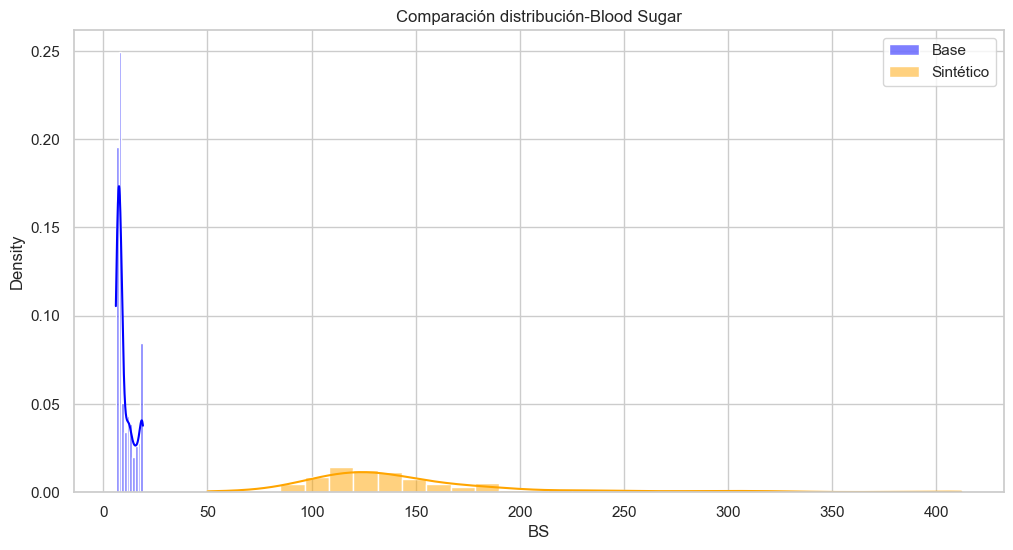

In [256]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable BloodSugar

sns.histplot(df['BS'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df5['BS'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-Blood Sugar')
plt.show()

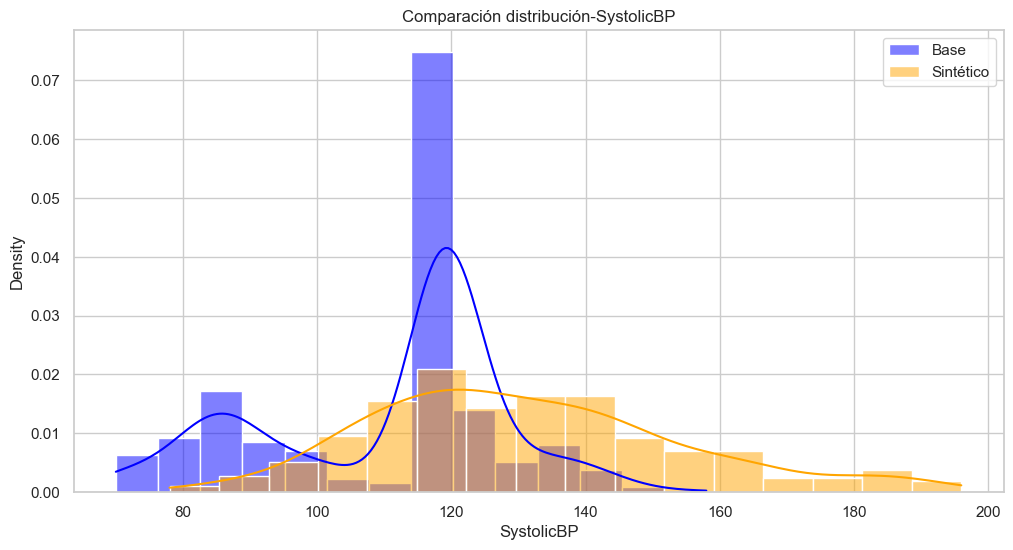

In [258]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable SystolicBP

sns.histplot(df['SystolicBP'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df5['SystolicBP'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-SystolicBP')
plt.show()

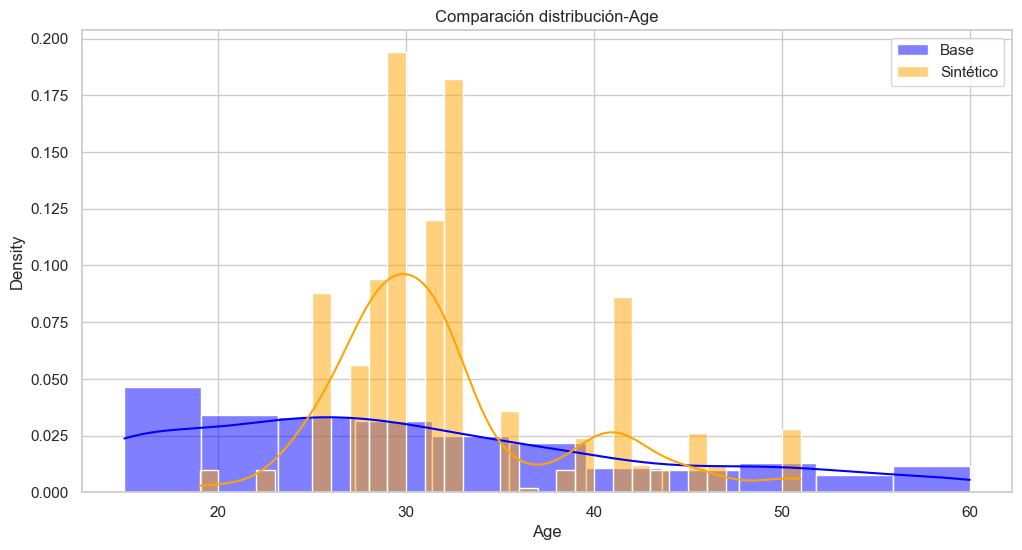

In [260]:
# Compara distribuciones con KDE e histogramas
plt.figure(figsize=(12, 6))

# Gráfico dataset base vs sintético para variable Age

sns.histplot(df['Age'], kde=True, color='blue', label='Base', stat='density')
sns.histplot(wearable_df5['Age'], kde=True, color='orange', label='Sintético', stat='density')
plt.legend()
plt.title('Comparación distribución-Age')
plt.show()

Podemos observar que de todas las simulaciones, la más parecida a los patrones que sigan las variables
en Maternal Health Risk dataset es esta última. Al ser una simulación, no nos preocupa que no sea idéntica al dataste base, pero
podemos observar que las distribuciones y la variación de los valores es parecida, al menos sabemos que siguen la misma naturaleza. 

# SIMULACIÓN PARA PRIMER MES DE GESTACIÓN

Usaremos los datos recogidos de un sólo día y los replicaremos para cubrir un mes. 
Para ello, hay que replicar los datos diarios por 30 días. Manteniendo las fluctuaciones diarias para cada uno de esos días. 

Nuestro siguiente objetivo será modificar gradualmente los signos vitales para reflejar su variación durante los 9 meses de embarazo. Como primera idea se nos ha ocurrido incluir un factor progresivo, que simule la variación.

In [262]:
from sdv.metadata import Metadata
import json
with open('metadata-1-month-augment.json') as archive:
    metadata_dict = json.load(archive)


In [264]:
metadata = Metadata.load_from_dict(metadata_dict)
metadata.validate()

C:\Users\virginia.anton\anaconda3\Lib\site-packages\sdv\metadata\metadata.py:130: UserWarning: No table name was provided to metadata containing only one table. Assigning name: table
  warnings.warn(


In [266]:
import pandas as pd

# 'timestamp' debe estar en formato datetime
user_wearable['timestamp'] = pd.to_datetime(user_wearable['timestamp'], errors='coerce')

# Cambiamos los valores al formato del df base
user_wearable['timestamp'] = user_wearable['timestamp'].dt.strftime('%d/%m/%Y %H:%M:%S')
print(user_wearable['timestamp'].head())



0    24/07/2024 08:00:00
1    24/07/2024 11:00:00
2    24/07/2024 14:00:00
3    24/07/2024 17:00:00
4    24/07/2024 20:00:00
Name: timestamp, dtype: object


C:\Users\virginia.anton\AppData\Local\Temp\ipykernel_16316\1613144134.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  user_wearable['timestamp'] = pd.to_datetime(user_wearable['timestamp'], errors='coerce')


In [278]:
from sdv.sequential import PARSynthesizer

# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata)

# Step 2: Train the synthesizer
synthesizer.fit(user_wearable)

# Step 3: Generate synthetic data
synthetic_data2 = synthesizer.sample(num_sequences=100)


C:\Users\virginia.anton\anaconda3\Lib\site-packages\sdv\single_table\base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [279]:
synthetic_data2.to_csv('01-first-month-simulation.csv')

In [282]:

# Ajustar los valores de las variables a los rangos fisiológicos:

synthetic_data2['Age'] = synthetic_data2['Age'].clip(lower=15, upper=60)
synthetic_data2['SystolicBP'] = synthetic_data2['SystolicBP'].clip(lower=70, upper=180)
synthetic_data2['DiastolicBP'] = synthetic_data2['DiastolicBP'].clip(lower=49, upper=100)
synthetic_data2['BS'] = synthetic_data2['BS'].clip(lower=6.0, upper=19.0)
synthetic_data2['BodyTemp'] = synthetic_data2['BodyTemp'].clip(lower=98.0, upper=103.0)
synthetic_data2['HeartRate'] = synthetic_data2['HeartRate'].clip(lower=7, upper=120)

synthetic_data2.head()

,user_id,Age,timestamp,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate
0,user_0095,32,13/06/2024 07:39:47,88,133,19.0,98.000000,104
1,user_0095,32,09/07/2024 10:38:00,91,130,19.0,98.785678,107
2,user_0095,32,03/07/2024 23:56:31,88,139,19.0,98.752471,114
3,user_0095,32,04/07/2024 20:10:13,84,132,19.0,99.147680,105
4,user_0095,32,30/06/2024 13:38:09,89,137,19.0,98.500718,117


In [288]:
synthetic_data2.describe()

,Age,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate
count,1370.000000,1370.000000,1370.000000,1370.0,1370.000000,1370.000000
mean,32.106569,88.743796,133.359124,19.0,98.816703,104.805839
std,0.431114,3.443276,5.027413,0.0,0.309367,5.420678
min,30.000000,78.000000,114.000000,19.0,98.000000,86.000000
25%,32.000000,87.000000,130.000000,19.0,98.616926,102.000000
50%,32.000000,89.000000,133.000000,19.0,98.799548,104.000000
75%,32.000000,91.000000,137.000000,19.0,99.005254,108.000000
max,34.000000,100.000000,150.000000,19.0,100.244690,120.000000


Vamos a comprobar si todos los datos recolectados para los usuarios se encuentran en el mismo periodo, 
Vamos a ver qué usuario corresponde la primera medida y a qué usuario corresponde la última medida guardada. 

In [294]:
# i. Obtener los valores mínimo y máximo de la columna timestamp
min_timestamp = synthetic_data2["timestamp"].min()
max_timestamp = synthetic_data2["timestamp"].max()

# ii. Identificar el usuario asociado al mínimo y máximo timestamp
min_user = synthetic_data2.loc[synthetic_data2["timestamp"] == min_timestamp, "user_id"].values
max_user = synthetic_data2.loc[synthetic_data2["timestamp"] == max_timestamp, "user_id"].values

# iii. Observamos los resultados
print(f"Min Timestamp: {min_timestamp} corresponde al usuario con ID: {min_user}")
print(f"Max Timestamp: {max_timestamp} corresponde al usuario con ID: {max_user}")

Min Timestamp: 01/04/2024 05:45:13 corresponde al usuario con ID: ['user_0060']
Max Timestamp: 31/08/2024 15:47:37 corresponde al usuario con ID: ['user_0022']


In [296]:
# Calcular el min y max timestamp para cada usuario
user_timestamp_range = synthetic_data2.groupby("user_id")["timestamp"].agg(["min", "max"]).reset_index()

# Mostrar el rango de timestamps para cada usuario
print(user_timestamp_range)


      user_id                  min                  max
0   user_0000  07/07/2024 02:00:43  27/07/2024 07:32:04
1   user_0001  02/06/2024 01:09:04  30/06/2024 20:51:36
2   user_0002  01/07/2024 10:13:44  31/05/2024 10:00:46
3   user_0003  01/07/2024 16:18:22  29/06/2024 22:45:15
4   user_0004  02/07/2024 22:41:10  27/06/2024 22:48:16
..        ...                  ...                  ...
95  user_0095  03/07/2024 23:56:31  30/06/2024 13:38:09
96  user_0096  31/05/2024 03:26:12  31/05/2024 03:26:12
97  user_0097  01/07/2024 08:20:48  28/06/2024 16:51:26
98  user_0098  01/07/2024 20:01:03  29/06/2024 16:29:05
99  user_0099  09/07/2024 16:19:55  25/06/2024 16:05:49

[100 rows x 3 columns]


Como se puede observar, los datos no parten de la misma fecha. Nos da igual que a lo largo del día unos datos
queden registrados a una hora y otros a otra, pero sí nos interesa tener el mismo número de medidas para cada usuario y
que empiecen y acaben en el mismo periodo de fechas, para simplificar el algoritmo.

Vamos a crear usuarios que se encuentren en el mismo rango y vamos a suponer que 
todas las pacientes han tenido la primera consulta en las mismas fechas, y haremos el seguimiento a la vez 
para esta muestra. Por ello, vamos a filtrar todos los usuarios que tengamos por ejemplo desde el 1 de Mayo de 2024 hasta
el 31 de Julio de 2024, y el seguimiento será alrededor de 9-10 meses. 

In [298]:
#Definimos periodo
def periodOfSimulation(start, end, df):
    filtered_data = df.query("timestamp >= @start and timestamp <= @end ")
    filtered_users = filtered_data["user_id"].unique()
    num_users = filtered_data["user_id"].nunique()
    return filtered_users, num_users
    

In [300]:
inicio = "01/06/2024 00:00:00"
fin = "31/07/2024 23:59:59"
filtered_users, num_users = periodOfSimulation(inicio, fin, synthetic_data2)
print(f"{num_users} usuarios que registraron datos desde {inicio}-{fin}:\n",filtered_users)

99 usuarios que registraron datos desde 01/06/2024 00:00:00-31/07/2024 23:59:59:
 ['user_0095' 'user_0074' 'user_0075' 'user_0048' 'user_0086' 'user_0017'
 'user_0098' 'user_0052' 'user_0092' 'user_0090' 'user_0071' 'user_0027'
 'user_0068' 'user_0083' 'user_0055' 'user_0070' 'user_0076' 'user_0018'
 'user_0033' 'user_0045' 'user_0057' 'user_0012' 'user_0004' 'user_0094'
 'user_0014' 'user_0088' 'user_0032' 'user_0080' 'user_0019' 'user_0061'
 'user_0036' 'user_0091' 'user_0096' 'user_0087' 'user_0064' 'user_0097'
 'user_0039' 'user_0072' 'user_0044' 'user_0011' 'user_0093' 'user_0029'
 'user_0062' 'user_0089' 'user_0073' 'user_0024' 'user_0043' 'user_0066'
 'user_0099' 'user_0051' 'user_0030' 'user_0005' 'user_0059' 'user_0079'
 'user_0042' 'user_0025' 'user_0010' 'user_0015' 'user_0047' 'user_0016'
 'user_0065' 'user_0082' 'user_0063' 'user_0031' 'user_0002' 'user_0050'
 'user_0013' 'user_0084' 'user_0053' 'user_0077' 'user_0009' 'user_0041'
 'user_0035' 'user_0034' 'user_0069' 'user

El dataset filtrado quedaría:

In [302]:
# Filtra por el periodo de interés
synthetic_data2= synthetic_data2[(synthetic_data2['timestamp'] >= inicio) & (synthetic_data2['timestamp'] < fin)]

In [304]:
min_timestamp = synthetic_data2["timestamp"].min()
max_timestamp = synthetic_data2["timestamp"].max()
print(min_timestamp, max_timestamp)

01/06/2024 07:29:36 31/07/2024 19:25:20


In [306]:
synthetic_data2.head()

,user_id,Age,timestamp,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate
0,user_0095,32,13/06/2024 07:39:47,88,133,19.0,98.000000,104
1,user_0095,32,09/07/2024 10:38:00,91,130,19.0,98.785678,107
2,user_0095,32,03/07/2024 23:56:31,88,139,19.0,98.752471,114
3,user_0095,32,04/07/2024 20:10:13,84,132,19.0,99.147680,105
4,user_0095,32,30/06/2024 13:38:09,89,137,19.0,98.500718,117


In [308]:
#comprobamos si  los usuarios que hemos encontrado antes están el dataset filtrado
# Obtener los usuarios únicos en el dataset filtrado
users_in_df = set(synthetic_data2['user_id'].unique())

# Convertir la lista de usuarios de interés en un conjunto
interested_users_set= set(filtered_users)

# Encontrar los usuarios que están en la lista de interés pero no en el dataset
missing_users = interested_users_set - users_in_df

# Imprimir el resultado
if missing_users:
    print(f"Usuarios que no están en el dataset: {missing_users}")
else:
    print("Todos los usuarios de la lista de interés están presentes en el dataset.")


Todos los usuarios de la lista de interés están presentes en el dataset.


Ahora vamos a comprobar que todos los usuarios tienen el mismo número de medidas al día. Dado que es 
el interfaz que, en caso de no recibir 3 medidas al día de forma voluntaria, se lo pide, de forma que 
no perdamos la continuidad e información durante los 9 meses. 

In [310]:
def verifica_medidas_porDia(df, user_col='user_id', timestamp_col='timestamp'):
    """
    Verifica si todos los usuarios tienen el mismo número de medidas al día. 
    Args:
        - df: dataframe 
        - user_col: columna con ids usuarios. 
        - timestamp_col : columna con timestamps. 
    Returns: 
        None: imprime resultados. 
    """
     #creamos fecha columna sin las horas
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce', dayfirst=True)

    df['date'] = df[timestamp_col].dt.date
    medidas_porDia = df.groupby([user_col, 'date']).size().reset_index(name='num_medidas')

    #verificar si todos los usuarios tienen mismo num de medidas al día
    medidas_unicas = medidas_porDia['num_medidas'].unique()
    
    if len(medidas_unicas)==1:
        print(f"Todos los usuarios tienen el mismo numero de medidas al día: {medidas_unicas[0]}")
    else:
            print(f"Los usuarios tienen diferentes números de medidas al día:{ medidas_porDia.groupby('num_medidas').size()}")
            plt.hist(medidas_porDia['num_medidas'], bins=range(1, medidas_porDia['num_medidas'].max() + 2), edgecolor='black')
            plt.title("Distribución del número de medidas al día")
            plt.xlabel("Número de medidas al día")
            plt.ylabel("Frecuencia")
            plt.xticks(range(1, medidas_porDia['num_medidas'].max() + 1))
            plt.show()

In [312]:
synCopy = synthetic_data2.copy()

Los usuarios tienen diferentes números de medidas al día:num_medidas
1    803
2    178
3     49
4      9
5      5
dtype: int64


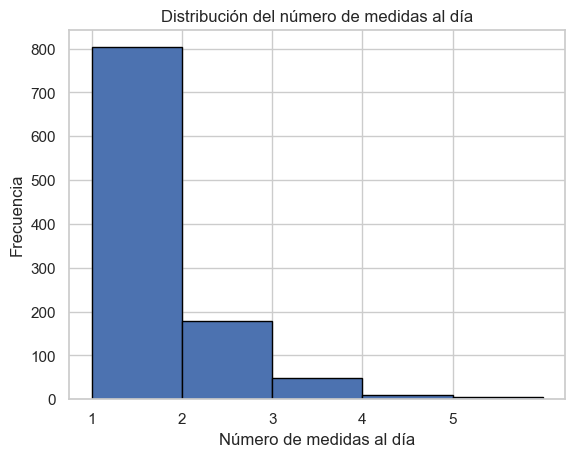

In [314]:
verifica_medidas_porDia(synCopy)

Para que tengan el mismo número de medidas, rellenamos los datos. Debemos tener cuidado de respetar las distribucioes individuales
y las correlaciones entre columnas. Para ello, podemos usar SDV (Synthetic Data Vault), tiene Modelos Temporales Condicionados (TimeSeriesTransformer), en concreto, vamos a emplear el modelo PAR (Probabilistic AutoRegressive) de dicha librería, para generar datos respetando las tendencias y correlaciones entre signos vitales. 


In [316]:
synthetic_data2.head()

,user_id,Age,timestamp,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate
0,user_0095,32,13/06/2024 07:39:47,88,133,19.0,98.000000,104
1,user_0095,32,09/07/2024 10:38:00,91,130,19.0,98.785678,107
2,user_0095,32,03/07/2024 23:56:31,88,139,19.0,98.752471,114
3,user_0095,32,04/07/2024 20:10:13,84,132,19.0,99.147680,105
4,user_0095,32,30/06/2024 13:38:09,89,137,19.0,98.500718,117


In [318]:
import pandas as pd

def summarize_missing_values(df):
    """
    Devuelve un resumen del número y porcentaje de valores NaN en cada columna de un DataFrame.

    Args:
        df (pd.DataFrame): DataFrame a analizar.

    Returns:
        pd.DataFrame: Resumen con columnas 'missing_count' y 'missing_percentage',
                      ordenado por la cantidad de valores faltantes en orden descendente.
    """
    missing_summary = pd.DataFrame({
        'missing_count': df.isnull().sum(),
        'missing_percentage': df.isnull().mean() * 100
    }).sort_values(by='missing_count', ascending=False)
    
    return missing_summary


# summary = summarize_missing_values(df)
# print(summary)


In [320]:
summary_synthetic_data = summarize_missing_values(synthetic_data2)
print(summary_synthetic_data)

             missing_count  missing_percentage
user_id                  0                 0.0
Age                      0                 0.0
timestamp                0                 0.0
DiastolicBP              0                 0.0
SystolicBP               0                 0.0
BS                       0                 0.0
BodyTemp                 0                 0.0
HeartRate                0                 0.0


Podemos observar que ha surgido un problema añadido, y es que no sólo faltan medidas por día en el usuario, es que no aparecen estas filas con
valores NaN para poder rellenar: vamos a reindexar el dataframe para que existan huecos que podamos rellenar. 

In [322]:
synthetic_data2['day'] =  pd.to_datetime(synthetic_data['timestamp'], errors='coerce', dayfirst=True)
synthetic_data2.head()


,user_id,Age,timestamp,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,day
0,user_0095,32,13/06/2024 07:39:47,88,133,19.0,98.000000,104,2024-07-23 01:24:27
1,user_0095,32,09/07/2024 10:38:00,91,130,19.0,98.785678,107,2024-06-21 21:23:04
2,user_0095,32,03/07/2024 23:56:31,88,139,19.0,98.752471,114,2024-07-25 03:49:41
3,user_0095,32,04/07/2024 20:10:13,84,132,19.0,99.147680,105,2024-06-15 08:01:52
4,user_0095,32,30/06/2024 13:38:09,89,137,19.0,98.500718,117,2024-06-19 13:46:44


In [324]:
import pandas as pd
import numpy as np

def add_measures_with_nans(df):
    """
    Añade un mínimo de 3 medidas al día con valores NaN salvo en 'Age', 'day', 'timestamp' y 'user_id',
    para que puedan ser interpolados después.
    """
    # Asegúrate de que la columna 'timestamp' sea de tipo datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')

    # Crea una columna 'day' que contiene solo la fecha (sin hora)
    df['day'] = df['timestamp'].dt.date

    # Crear un nuevo DataFrame para almacenar los resultados
    expanded_df = pd.DataFrame()

    # Iterar sobre cada usuario
    for user_id, user_data in df.groupby('user_id'):
        # Iterar sobre cada día del usuario
        for day, day_data in user_data.groupby('day'):
            # Añadir las filas originales del día
            expanded_df = pd.concat([expanded_df, day_data])

            # Si ya hay al menos 3 medidas, no es necesario añadir
            if len(day_data) >= 3:
                continue

            # Añadir medidas adicionales para alcanzar un mínimo de 3 por día
            additional_measures = 3 - len(day_data)
            for i in range(additional_measures):
                # Generar timestamps espaciados (8 horas) dentro del mismo día
                new_timestamp = day_data['timestamp'].iloc[0] + pd.Timedelta(hours=8 * (i + 1))
                if new_timestamp.date() != day:  # Asegurarse de que sigue siendo el mismo día
                    new_timestamp = pd.Timestamp(day) + pd.Timedelta(hours=8 * (i + 1))
                
                # Crear una nueva fila con NaN excepto en 'Age', 'day', 'timestamp' y 'user_id'
                new_row = {col: np.nan for col in df.columns}
                new_row['user_id'] = user_id
                new_row['day'] = day
                new_row['timestamp'] = new_timestamp
                
                # Si 'Age' está en las columnas, conservar el valor original
                if 'Age' in df.columns:
                    new_row['Age'] = day_data['Age'].iloc[0]
                
                # Añadir la nueva fila al DataFrame expandido
                expanded_df = pd.concat([expanded_df, pd.DataFrame([new_row])])

    # Ordenar el DataFrame por usuario y timestamp
    expanded_df = expanded_df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)
    return expanded_df


In [326]:
# Aplicar la función por usuario y día
# Ordenar el dataframe para que sea más sencillo la ampliación
synt_expanded = synthetic_data2.sort_values(by=['user_id', 'timestamp'])
#print(synt_expanded)
synt_expanded = add_measures_with_nans(synthetic_data2)
print(synt_expanded)

        user_id  Age           timestamp  DiastolicBP  SystolicBP    BS  \
0     user_0000   32 2024-05-19 13:11:47         79.0       123.0  19.0   
1     user_0000   32 2024-05-19 16:00:00          NaN         NaN   NaN   
2     user_0000   32 2024-05-19 21:11:47          NaN         NaN   NaN   
3     user_0000   33 2024-07-07 02:00:43         93.0       126.0  19.0   
4     user_0000   33 2024-07-07 10:00:43          NaN         NaN   NaN   
...         ...  ...                 ...          ...         ...   ...   
3146  user_0099   32 2024-07-09 16:00:00          NaN         NaN   NaN   
3147  user_0099   32 2024-07-09 16:19:55         92.0       135.0  19.0   
3148  user_0099   32 2024-07-15 11:39:16         91.0       134.0  19.0   
3149  user_0099   32 2024-07-15 16:00:00          NaN         NaN   NaN   
3150  user_0099   32 2024-07-15 19:39:16          NaN         NaN   NaN   

       BodyTemp  HeartRate         day  
0     98.527641      106.0  2024-05-19  
1           NaN  

summary_expanded_data = summarize_missing_values(synt_expanded)
print(summary_expanded_data)

Ahora podemos insertar datos en las celdas 'NaN'

## INSERCIÓN DE DATOS EN EL DATASET

Volvemos a cargar nuestro dataframe sintético para un mes y hacemos copia del sintético
con datos NaN añadidos para no perder los originales. Vamos a estudiar varias formas de interpolación y escoger la más 
adecuada. 

In [436]:
import json
import pandas as pd

# Ruta al archivo JSON
file_path = "synthetic_data"

# Abrir y cargar el fichero JSON
with open(file_path, "r") as file:
    data = json.load(file)

# Convertir a DataFrame
synthetic_data= pd.DataFrame(data)

# Mostrar el DataFrame
print(synthetic_data)

        user_id  Age            timestamp  DiastolicBP  SystolicBP  \
0     user_0067   34  08/08/2024 01:34:04           87         138   
1     user_0067   32  31/05/2024 11:45:11           89         128   
2     user_0067   32  26/06/2024 20:55:18           88         130   
3     user_0067   32  30/06/2024 19:43:49           89         131   
4     user_0067   32  12/07/2024 06:49:47           93         124   
...         ...  ...                  ...          ...         ...   
1239  user_0031   32  08/07/2024 11:17:50           88         133   
1240  user_0031   32  23/06/2024 17:13:46           87         126   
1241  user_0031   32  13/06/2024 11:28:02           85         131   
1242  user_0031   32  24/07/2024 17:52:15           88         135   
1243  user_0031   32  12/07/2024 08:53:07           88         133   

              BS   BodyTemp  HeartRate  
0     141.754328  98.768251        103  
1     154.794219  98.602028        109  
2     150.354816  99.313066        1

In [438]:
expDataNaN= synt_expanded.copy()
print(expDataNaN)

        user_id  Age           timestamp  DiastolicBP  SystolicBP    BS  \
0     user_0000   32 2024-05-19 13:11:47         79.0       123.0  19.0   
1     user_0000   32 2024-05-19 16:00:00          NaN         NaN   NaN   
2     user_0000   32 2024-05-19 21:11:47          NaN         NaN   NaN   
3     user_0000   33 2024-07-07 02:00:43         93.0       126.0  19.0   
4     user_0000   33 2024-07-07 10:00:43          NaN         NaN   NaN   
...         ...  ...                 ...          ...         ...   ...   
3146  user_0099   32 2024-07-09 16:00:00          NaN         NaN   NaN   
3147  user_0099   32 2024-07-09 16:19:55         92.0       135.0  19.0   
3148  user_0099   32 2024-07-15 11:39:16         91.0       134.0  19.0   
3149  user_0099   32 2024-07-15 16:00:00          NaN         NaN   NaN   
3150  user_0099   32 2024-07-15 19:39:16          NaN         NaN   NaN   

       BodyTemp  HeartRate         day  
0     98.527641      106.0  2024-05-19  
1           NaN  

### Opción 1: Función para rellenar con referencia al día anterior/posterior

Vamos a usar el relleno hacia delante y el relleno hacia atrás para obtener valores aproximados
de días anteriores y posteriores, y luego aplicamos interpolación temporal para suavizar los valores

In [440]:
def insercionConDatosPrevios(df):
    """
    Rellena los valores NaN basándose en el día anterior o Posterior para filas insertadas. 
    ARGS:
        - df: dataframe con columnas NaN. 
    RETURNS:
        - pd.Dataframe: dataframe con valores insertados. 
    """

#Nos aseguramos que el índice es el timestamp
    if 'timestamp' in df.columns:
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'], errors = 'coerce')
            df.set_index('timestamp', inplace = True)
        
    #Identifico columnas numericas
    col_numericas = df.select_dtypes(include=['float64', 'int64']).columns 
    
    df_ffill = df[col_numericas].ffill() #valores día anterior
    df_bfill = df[col_numericas].bfill() #valores día posterior
   
    #promedio entre estos valores
    df_promedio = (df_ffill + df_bfill)/2
    
    #Insertamos valores en dataframe original 
    df.update(df_promedio)
    
    df[col_numericas] = df[col_numericas].interpolate(method='time')

    #indices originales intactos
    return df_promedio

In [442]:
syn_datosprevios = insercionConDatosPrevios(expDataNaN)
print(syn_datosprevios)

                      Age  DiastolicBP  SystolicBP    BS   BodyTemp  HeartRate
timestamp                                                                     
2024-05-19 13:11:47  32.0         79.0       123.0  19.0  98.527641      106.0
2024-05-19 16:00:00  32.0         86.0       124.5  19.0  98.745794      105.5
2024-05-19 21:11:47  32.0         86.0       124.5  19.0  98.745794      105.5
2024-07-07 02:00:43  33.0         93.0       126.0  19.0  98.963946      105.0
2024-07-07 10:00:43  33.0         91.5       126.5  19.0  98.999961      104.0
...                   ...          ...         ...   ...        ...        ...
2024-07-09 16:00:00  32.0         92.5       134.0  19.0  98.483569      106.0
2024-07-09 16:19:55  32.0         92.0       135.0  19.0  98.696800      112.0
2024-07-15 11:39:16  32.0         91.0       134.0  19.0  99.427238      107.0
2024-07-15 16:00:00  32.0          NaN         NaN   NaN        NaN        NaN
2024-07-15 19:39:16  32.0          NaN         NaN  

### Opción 2: Interpolación con K.Nearest Neighbors (KNN)

Este algoritmo inserta valores basándose en los máss cercanos, y no según el día anterior o posterior 
como en el anterior

In [455]:
from fancyimpute import KNN

def insercionConKNN(df, k):
    """
    Interpola valores faltantes en un Dataframe usando K-Nearest Neighbors. 

    ARGS:
        - df: Dataframe a insertar valores. 
        - k: Número de vecinos a considerar para KNN. 
    RETURNS:
        - pd.Dataframe: Dataframe con valores interpolados. 
    """

    #Transformo dataframe a matriz numerica

    matrixDf = df.select_dtypes(include=['float', 'int64'])
    imputed_array = KNN(k=k).fit_transform(matrixDf)

    #Convertir la matriz interpolada de vuelta a df original

    interpolated_df = df.copy()
    interpolated_df[matrixDf.columns] = imputed_array
    print(interpolated_df)

    return interpolated_df
    
    

In [457]:
syn_knn = insercionConKNN(synt_expanded, 6)
syn_knn.head()

Imputing row 1/3151 with 0 missing, elapsed time: 1.558
Imputing row 101/3151 with 0 missing, elapsed time: 1.574
Imputing row 201/3151 with 5 missing, elapsed time: 1.585
Imputing row 301/3151 with 5 missing, elapsed time: 1.598
Imputing row 401/3151 with 0 missing, elapsed time: 1.610
Imputing row 501/3151 with 0 missing, elapsed time: 1.622
Imputing row 601/3151 with 0 missing, elapsed time: 1.637
Imputing row 701/3151 with 0 missing, elapsed time: 1.651
Imputing row 801/3151 with 5 missing, elapsed time: 1.664
Imputing row 901/3151 with 5 missing, elapsed time: 1.680
Imputing row 1001/3151 with 0 missing, elapsed time: 1.691
Imputing row 1101/3151 with 5 missing, elapsed time: 1.704
Imputing row 1201/3151 with 0 missing, elapsed time: 1.718
Imputing row 1301/3151 with 0 missing, elapsed time: 1.732
Imputing row 1401/3151 with 5 missing, elapsed time: 1.741
Imputing row 1501/3151 with 0 missing, elapsed time: 1.755
Imputing row 1601/3151 with 0 missing, elapsed time: 1.770
Imputing 

,user_id,Age,timestamp,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,day
0,user_0000,32.0,2024-05-19 13:11:47,79.000000,123.000000,19.0,98.527641,106.000000,2024-05-19
1,user_0000,32.0,2024-05-19 16:00:00,86.833333,130.666667,19.0,98.835576,106.333333,2024-05-19
2,user_0000,32.0,2024-05-19 21:11:47,86.833333,130.666667,19.0,98.835576,106.333333,2024-05-19
3,user_0000,33.0,2024-07-07 02:00:43,93.000000,126.000000,19.0,98.963946,105.000000,2024-07-07
4,user_0000,33.0,2024-07-07 10:00:43,89.166667,129.666667,19.0,98.701334,108.166667,2024-07-07


In [463]:
syn_knn.isnull().values.any()

False

### Opción 3: Con Redes Neuronales (ANN)

Permite capturar patrones más complejos

In [424]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer

def insercionConANN(df, target_columns):
    """
    Interpola valores faltantes usando MLP, una red neuronal. 
    ARGS:
        - df: dataframe con valores faltantes
        - target_columns (lista): lista de columnas para hacer interpoalción. 
    RETURNS:
        - pd.Dataframe: Dataframe con valores interpolados. 
    """

    df_interpolated = df.copy()
    
    # Seleccionar solo columnas numéricas
    numeric_predictors = df.select_dtypes(include=['float64', 'int64']).drop(columns=target_columns, errors='ignore')

    for target_col in target_columns: 

        if target_col not in df.columns or df[target_col].dtype not in ['float64', 'int64']:
            raise ValueError(f"La columna objetivo '{target_col}' no es numérica o no existe en el DataFrame.")
        
        #definimos predictores y objetivo
        predictors = numeric_predictors.copy()
        target = df[target_col]
        # Imputar valores faltantes en los predictores (solo para entrenamiento)
    
    imputer = SimpleImputer(strategy='mean')

    #dividir datos completos e incompletos
    train_x= predictors[target.notna()]
    train_y= target[target.notna()]
    test_x = predictors[target.isna()]

    #configurar y entrenar la red 
    mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
    mlp.fit(train_x, train_y)

    #predicción de valores
    df_interpolated.loc[target.isna(), target_col] = mlp.predict(test_x)

    return df_interpolated
    
    

In [354]:
target_columns = ['DiastolicBP', 'SystolicBP', 'BS', 'BodyTemp', 'HeartRate']
synt_ANN = insercionConANN(synt_expanded, target_columns)
print(synt_ANN)

        user_id  Age           timestamp  DiastolicBP  SystolicBP    BS  \
0     user_0000   32 2024-05-19 13:11:47         79.0       123.0  19.0   
1     user_0000   32 2024-05-19 16:00:00          NaN         NaN   NaN   
2     user_0000   32 2024-05-19 21:11:47          NaN         NaN   NaN   
3     user_0000   33 2024-07-07 02:00:43         93.0       126.0  19.0   
4     user_0000   33 2024-07-07 10:00:43          NaN         NaN   NaN   
...         ...  ...                 ...          ...         ...   ...   
3146  user_0099   32 2024-07-09 16:00:00          NaN         NaN   NaN   
3147  user_0099   32 2024-07-09 16:19:55         92.0       135.0  19.0   
3148  user_0099   32 2024-07-15 11:39:16         91.0       134.0  19.0   
3149  user_0099   32 2024-07-15 16:00:00          NaN         NaN   NaN   
3150  user_0099   32 2024-07-15 19:39:16          NaN         NaN   NaN   

       BodyTemp   HeartRate         day  
0     98.527641  106.000000  2024-05-19  
1           NaN

Vemos que este método falla porque hay columnas con muchos NaN, por tanto no es capaz de predicirlo. 

El único método que rellena bien los datos es KNN. 

### COMPROBACIÓN DISTRIBUCIÓN DE DATOS

Vamos a comprobar que todos los datos se distribuyen en el mes de junio a julio como queremos, y en caso
de encontrar más datos, guardar el dataset sólo con los datos y usuarios de esos meses.

In [447]:
def count_data_per_month(df, date_col):
    """
    Cuenta el número de datos por mes en un DataFrame. 
    Args:
        df: Dataframe
        date_col: columna con fechas formato datetime
    Returns: 
        pd.Dataframe con el conteo de datos por mes
    """
    df['month&year'] = pd.to_datetime(df[date_col])
    df['month&year'] = df['month&year'].dt.to_period('M')
    
    # Contar datos por mes
    conteo_mensual = df.groupby('month&year').size().reset_index(name='conteo')
    
    return conteo_mensual

In [449]:
conteo_mensual = count_data_per_month(syn_knn, 'day')
print(conteo_mensual)

  month&year  conteo
0    2024-04      12
1    2024-05     105
2    2024-06    1593
3    2024-07    1384
4    2024-08      51
5    2024-09       6


In [451]:
# Filtrar los meses de junio y julio de 2024
syn_knn_filtrado = syn_knn[(syn_knn['timestamp'] >= '2024-06') & (syn_knn['timestamp'] <= '2024-07')]
print(syn_knn_filtrado)

        user_id   Age           timestamp  DiastolicBP  SystolicBP    BS  \
12    user_0001  31.0 2024-06-02 01:09:04    87.000000  138.000000  19.0   
13    user_0001  31.0 2024-06-02 09:09:04    89.500000  139.000000  19.0   
14    user_0001  31.0 2024-06-02 17:09:04    89.500000  139.000000  19.0   
15    user_0001  32.0 2024-06-26 02:03:00    89.000000  131.000000  19.0   
16    user_0001  32.0 2024-06-26 10:03:00    86.833333  130.666667  19.0   
...         ...   ...                 ...          ...         ...   ...   
3140  user_0099  32.0 2024-06-22 16:00:00    86.833333  130.666667  19.0   
3141  user_0099  32.0 2024-06-22 17:36:09    86.000000  131.000000  19.0   
3142  user_0099  32.0 2024-06-25 08:00:00    86.833333  130.666667  19.0   
3143  user_0099  32.0 2024-06-25 16:00:00    86.833333  130.666667  19.0   
3144  user_0099  32.0 2024-06-25 16:05:49    93.000000  133.000000  19.0   

       BodyTemp   HeartRate         day month&year  
12    98.569345  115.000000  2024-

In [467]:
syn_knn_filtrado.to_csv('wearable-primerMes-knn-syn.csv', index=False)  # index=False evita guardar el índice del DataFrame